First, import the neccessary packages for this project. From there define your dataset into a dataframe.

# Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Introduction:

This project consisted of obtaining a dataset of house sales from King County in Washington State. From there I was tasked to develop a multi-linear regression model in order to accurately predict housing prices from this dataset. The framework behind developing this model involved following the OSEMiN Data Science Process. This process consists of 5 key steps: 

* Obtain: 
    * Extracting the data 
* Scrub: 
    * Preprocessing the data for the model 
    * Examples include normalizing the data, removing or replacing null values, or dealing with outliers
* Explore: 
    * This step tends to blend in with the "Scrub" step 
    * Check for multicollinearity, visualize and explore the data to have an understanding of how to prepare the predictors and whether any can be dropped in order to have more accurate model
    * Usually categorizing and binning the data happens after this step in order to minimize the visualizations created
* Model: 
    * The data is modeled and evaluated based on a number of parameters
    * From there, different trails are run in which the data is again scrubbed and explored to see how it can improve the model potentially
* Interpret: 
    * The results of the model are interpreted and echoed to stakeholders .
    * From here you decide if the model is satisfactory or if further steps are needed to improve 
    
In addition, 3 meaningful questions are to be addressed through the development of a model. These questions are: 

1. 
2. 
3. 

# 1. Obtaining Data 

In [2]:
df=pd.read_csv('kc_house_data.csv')
dff=df.copy()
print(df.shape)
df.head()

(21597, 21)


id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

# 2. Data Scrubbing

## Dealing with Null Values

We can then begin our data scrubbing process. First evaluate the column names then evaluate the null values in each column

In [3]:
print(df.columns)
df.isna().sum()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The columns waterfront and yr_renovated have a signficant amount of null values to where further evaluation is needed. The low number of null values in the view column allow for us to simply delete rows that contain these null values. This will be done after first evaluating the other two columns. First let's look and see the unique values for waterfront.

In [4]:
df.waterfront.unique()

array([nan,  0.,  1.])

This seems to indicate that either the property is facing the waterfront, not facing, or there is a null value. To evaluate how one can designate the null values, the price of these properties with respect to the 3 waterfront values is analyzed using a boxplot.

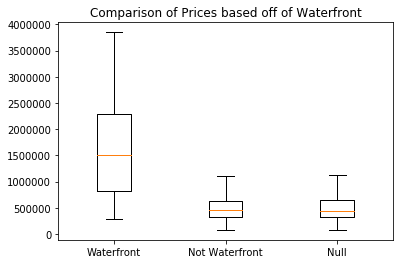

In [5]:
yes=df.price[df['waterfront']==1]
no=df.price[df['waterfront']==0]
maybe=df.price[df['waterfront'].isna()]
plt.boxplot([yes,no,maybe],labels=['Waterfront','Not Waterfront', 'Null'],showfliers=False)
plt.title('Comparison of Prices based off of Waterfront')
plt.show()

Waterfront seems to cause an increase in price but this would have to be further evaluated later. More importantly, it seems that when the waterfront value is null it most resembles when the property is not waterfront. Thus these NaN values can be replace with 0.

In [6]:
df.waterfront.fillna(0,inplace=True)
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

The focus then shifts to yr_renovated where we repeat the same process of evaluating how we can change the NaN values

In [7]:
df.yr_renovated.value_counts()


0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

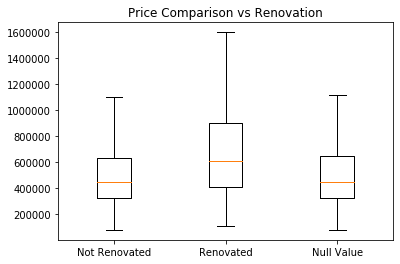

In [8]:
not_renovated=df.price[df['yr_renovated']==0]
renovated=df.price[(df['yr_renovated']!=0) &(df['yr_renovated'].notna())]
null_ren=df.price[df['yr_renovated'].isna()]
plt.boxplot([not_renovated,renovated,null_ren],labels=['Not Renovated','Renovated','Null Value'],showfliers=False)
plt.title('Price Comparison vs Renovation')
plt.show()

The same conclusions can be drawn in which all the null values are replaces with 0 as they seem to exhibit similar behavior.

In [9]:
df.yr_renovated.fillna(0,inplace=True)
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
view             63
condition         0
grade             0
sqft_above        0
sqft_basement     0
yr_built          0
yr_renovated      0
zipcode           0
lat               0
long              0
sqft_living15     0
sqft_lot15        0
dtype: int64

The remaining 63 null values can be dropped. 

In [10]:
df.view.unique()

array([ 0., nan,  3.,  4.,  2.,  1.])

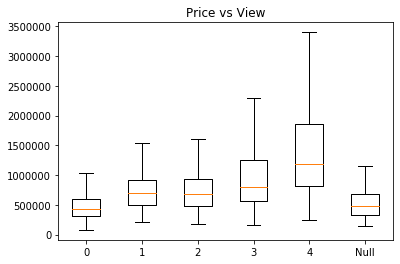

In [11]:
zero=df.price[df['view']==0]
one=df.price[df['view']==1]
two=df.price[df['view']==2]
three=df.price[df['view']==3]
four=df.price[df['view']==4]
null_view=df.price[df['view'].isna()]
plt.boxplot([zero,one,two,three,four,null_view],labels=['0','1','2','3','4','Null'],showfliers=False)
plt.title('Price vs View')
plt.show()

It seems as though the null values can be replaced for 0 yet because they are only 63 NaN values in the view column, it can be dropped as well. For now, the values will be replaced by 0. 

In [12]:
df.view.fillna(0,inplace=True)
print(df.isna().sum())
print(df.info())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above  

It seems as though the variable "sqft_basement" is listed as an object type. This needs to be changed to float type in order to perform then neccessary analysis.

In [13]:
df.sqft_basement.unique()

array(['0.0', '400.0', '910.0', '1530.0', '?', '730.0', '1700.0', '300.0',
       '970.0', '760.0', '720.0', '700.0', '820.0', '780.0', '790.0',
       '330.0', '1620.0', '360.0', '588.0', '1510.0', '410.0', '990.0',
       '600.0', '560.0', '550.0', '1000.0', '1600.0', '500.0', '1040.0',
       '880.0', '1010.0', '240.0', '265.0', '290.0', '800.0', '540.0',
       '710.0', '840.0', '380.0', '770.0', '480.0', '570.0', '1490.0',
       '620.0', '1250.0', '1270.0', '120.0', '650.0', '180.0', '1130.0',
       '450.0', '1640.0', '1460.0', '1020.0', '1030.0', '750.0', '640.0',
       '1070.0', '490.0', '1310.0', '630.0', '2000.0', '390.0', '430.0',
       '850.0', '210.0', '1430.0', '1950.0', '440.0', '220.0', '1160.0',
       '860.0', '580.0', '2060.0', '1820.0', '1180.0', '200.0', '1150.0',
       '1200.0', '680.0', '530.0', '1450.0', '1170.0', '1080.0', '960.0',
       '280.0', '870.0', '1100.0', '460.0', '1400.0', '660.0', '1220.0',
       '900.0', '420.0', '1580.0', '1380.0', '475.0', 

There seems to be some values listed as '?'. The choice here is to replace these values via a statstical or logical reason or drop them as they only account for 2%. However, based of the column name descriptions it is possible that sqft_basement = sqft_living - sqft_above. Thus, lets first see if this holds true at first glance.

In [14]:
df.loc[:,['sqft_living','sqft_above','sqft_basement']]

sqft_living  sqft_above sqft_basement
0             1180        1180           0.0
1             2570        2170         400.0
2              770         770           0.0
3             1960        1050         910.0
4             1680        1680           0.0
...            ...         ...           ...
21592         1530        1530           0.0
21593         2310        2310           0.0
21594         1020        1020           0.0
21595         1600        1600           0.0
21596         1020        1020           0.0

[21597 rows x 3 columns]

It seems as though this might be the case thus lets find out via a boolean comparison. First we should ensure that the dtype for all columns are the same and we have to drop the '?' as this would error. 

In [15]:
test_df=df.copy()
test_df=test_df[test_df.sqft_basement!='?']
test_df.shape
test_df.sqft_basement[test_df.sqft_basement=='0.0']=0
test_df.sqft_basement=test_df.sqft_basement.astype(float)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 21 columns):
id               21143 non-null int64
date             21143 non-null object
price            21143 non-null float64
bedrooms         21143 non-null int64
bathrooms        21143 non-null float64
sqft_living      21143 non-null int64
sqft_lot         21143 non-null int64
floors           21143 non-null float64
waterfront       21143 non-null float64
view             21143 non-null float64
condition        21143 non-null int64
grade            21143 non-null int64
sqft_above       21143 non-null int64
sqft_basement    21143 non-null float64
yr_built         21143 non-null int64
yr_renovated     21143 non-null float64
zipcode          21143 non-null int64
lat              21143 non-null float64
long             21143 non-null float64
sqft_living15    21143 non-null int64
sqft_lot15       21143 non-null int64
dtypes: float64(9), int64(11), object(1)
memory usage: 3.5+ MB


In [16]:
(test_df.sqft_basement!=test_df.sqft_living-test_df.sqft_above).sum()

0

Thus we can conclude that any row with a value of '?' in the sqft_basement column can be replaced by using the data from sqft_living and sqft_above. 

In [17]:
difference= (df.loc[df["sqft_basement"]=='?', ["sqft_living"]
                   ]).values-(df.loc[df["sqft_basement"]=='?', ["sqft_above"]]).values
df.loc[df["sqft_basement"]=='?', ["sqft_basement"]]=difference

In [18]:
df.sqft_basement=df.sqft_basement.astype(float)
df.sqft_basement=df.sqft_basement.astype('int64')

Next, we can see that the column 'id' is not a object type thus this needs to be changed as these values have no actual statistical value but rather are simply for the means of identification. 

In [19]:
df.id=df.id.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null object
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


It seems as though, the column data is not a datetime dtype. 

In [20]:
df['date'] = df['date'].astype('datetime64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null object
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null int64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(8), int64(11), object(1)
memory 

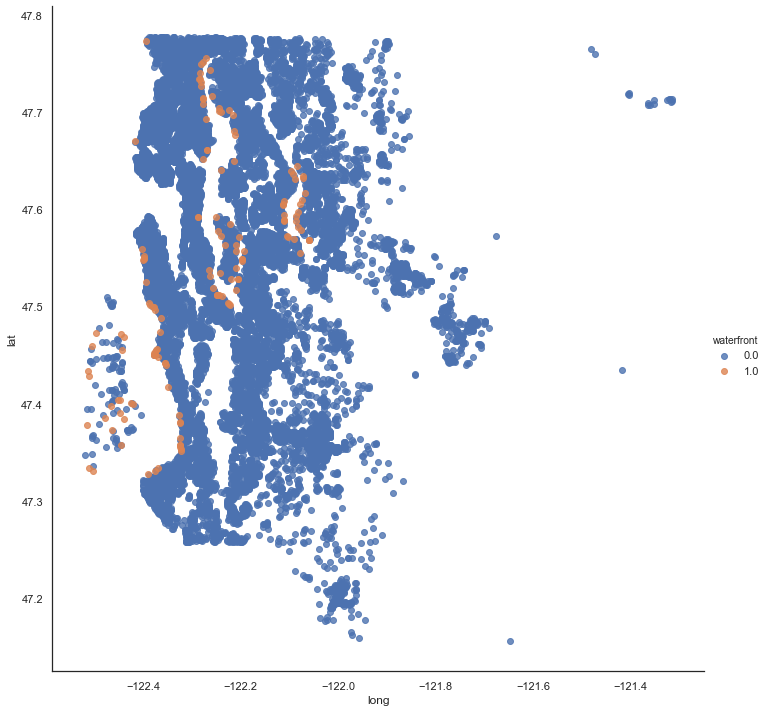

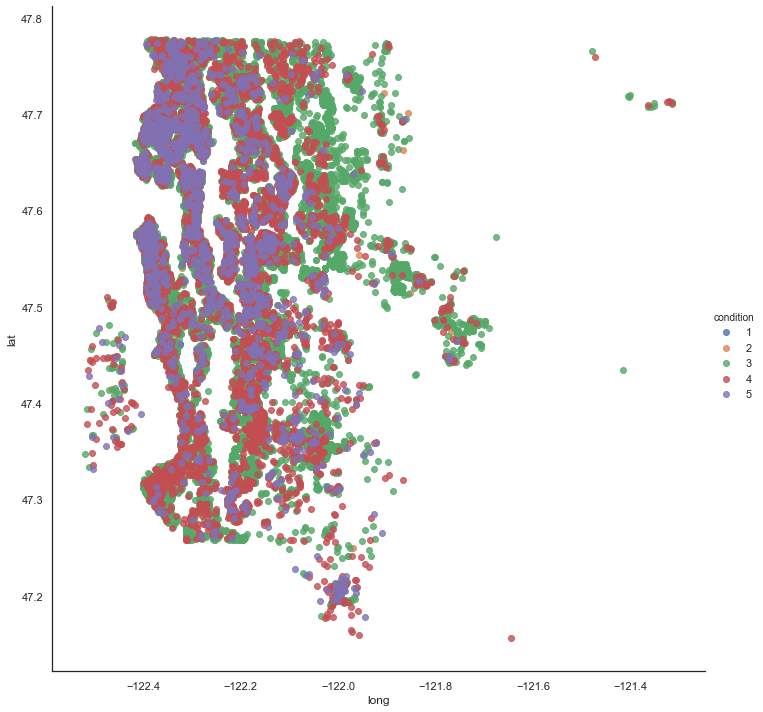

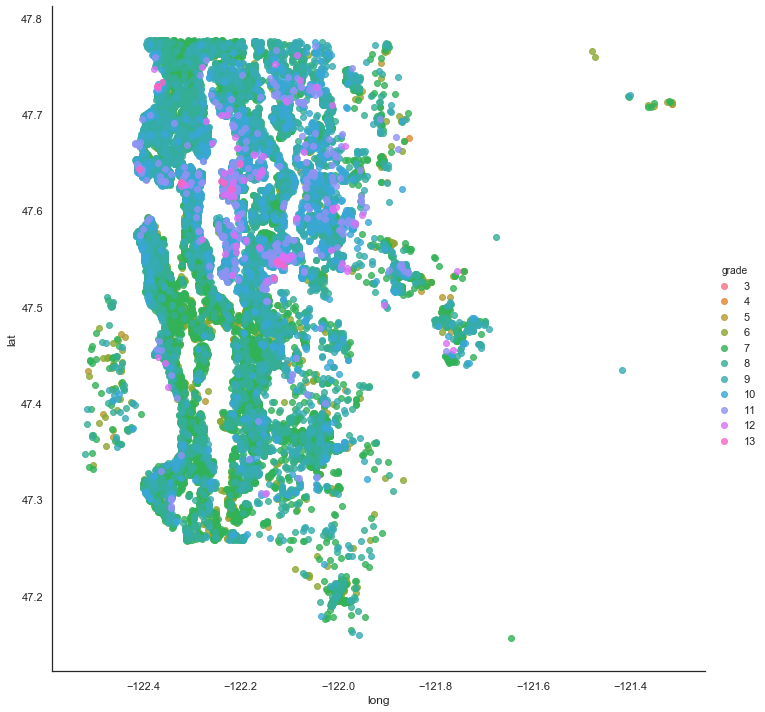

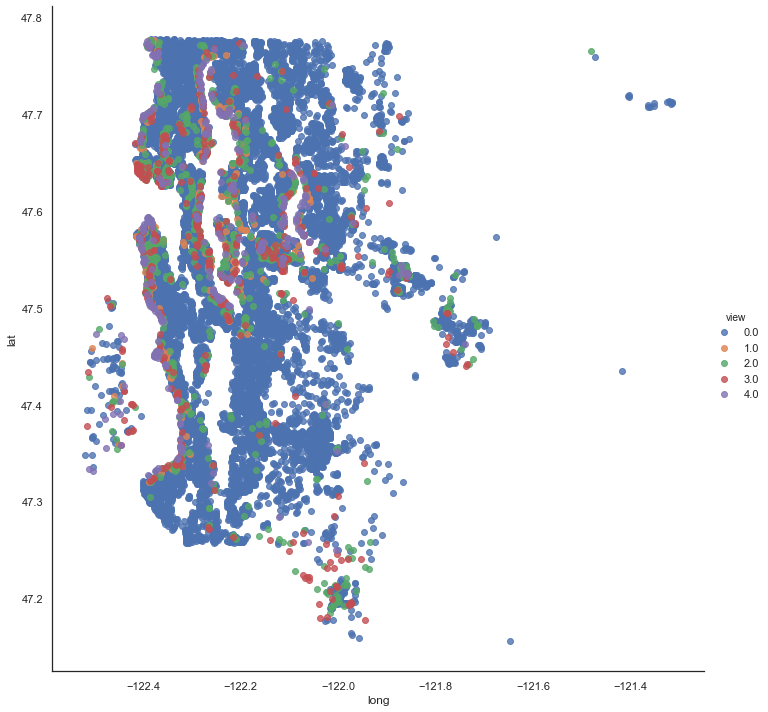

In [851]:
for col in ['waterfront','condition','grade','view']:
    g = sns.lmplot(data=df,x='long',y='lat',hue=col,height=10,fit_reg=False)

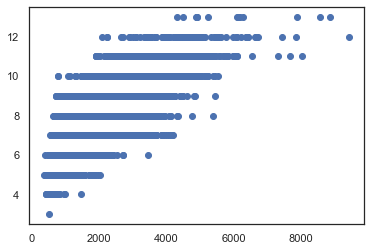

pd.plotting.scatter_matrix(df,figsize=(25,15))
plt.show()

In [853]:
df2=df.copy()

# 3. Exploratory Data Analysis

First, let's observe the statistical features of the predictors and the target variable. From there we can observe the distribution of each variable to see if any further manipulation of data is necessary. 

In [22]:
df.describe()


price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  2.159700e+04   
mean   5.402966e+05      3.373200      2.115826   2080.321850  1.509941e+04   
std    3.673681e+05      0.926299      0.768984    918.106125  4.141264e+04   
min    7.800000e+04      1.000000      0.500000    370.000000  5.200000e+02   
25%    3.220000e+05      3.000000      1.750000   1430.000000  5.040000e+03   
50%    4.500000e+05      3.000000      2.250000   1910.000000  7.618000e+03   
75%    6.450000e+05      4.000000      2.500000   2550.000000  1.068500e+04   
max    7.700000e+06     33.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  21597.000000  21597.000000  21597.000000  21597.000000  21597.000000   
mean       1.494096      0.006760      0.233181      3.409825      7.657915   
std        0.539683      0.081944      0.764673      0.650546      1.173200   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated       zipcode  \
count  21597.000000   21597.000000  21597.000000  21597.000000  21597.000000   
mean    1788.596842     291.725008   1970.999676     68.758207  98077.951845   
std      827.759761     442.667800     29.375234    364.037499     53.513072   
min      370.000000       0.000000   1900.000000      0.000000  98001.000000   
25%     1190.000000       0.000000   1951.000000      0.000000  98033.000000   
50%     1560.000000       0.000000   1975.000000      0.000000  98065.000000   
75%     2210.000000     560.000000   1997.000000      0.000000  98118.000000   
max     9410.000000    4820.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15  
count  21597.000000  21597.000000   21597.000000   21597.000000  
mean      47.560093   -122.213982    1986.620318   12758.283512  
std        0.138552      0.140724     685.230472   27274.441950  
min       47.155900   -122.519000     399.000000     651.000000  
25%       47.471100   -122.328000    1490.000000    5100.000000  
50%       47.571800   -122.231000    1840.000000    7620.000000  
75%       47.678000   -122.125000    2360.000000   10083.000000  
max       47.777600   -121.315000    6210.000000  871200.000000

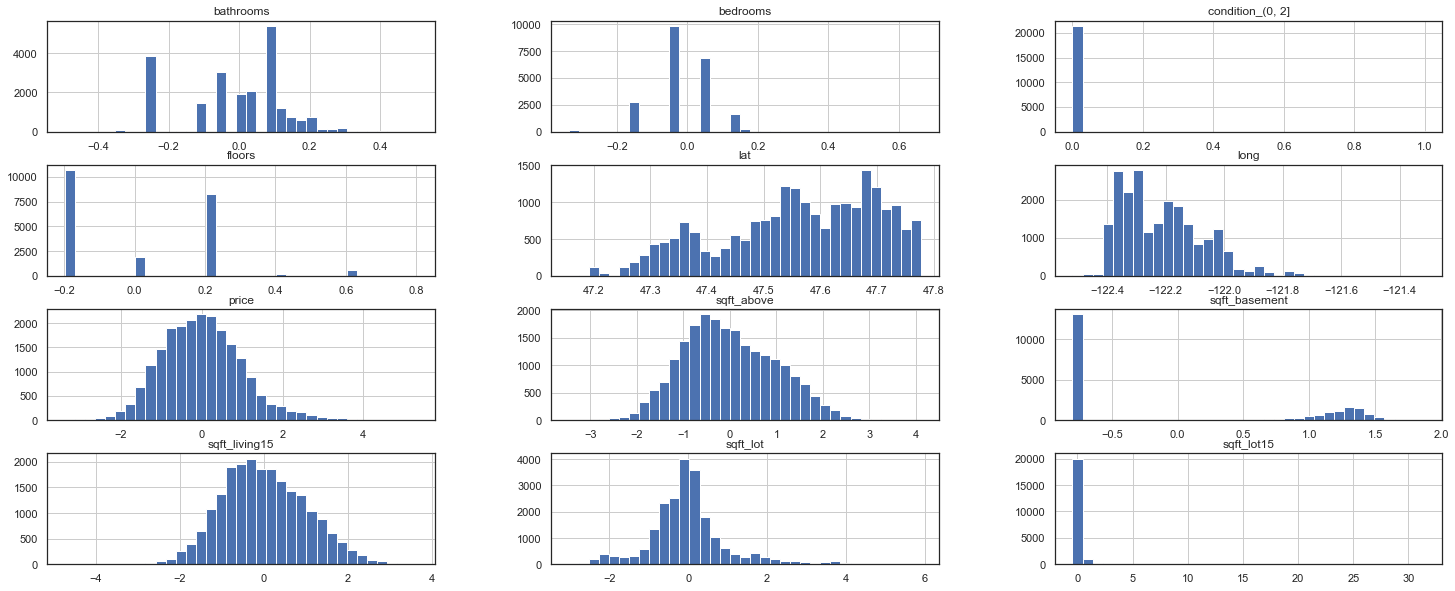

In [855]:
new_df.iloc[:,0:14].hist(figsize=(25,10),bins=35)
plt.show()

## Categorical Variable Designation/Further Data Cleaning

After review of the histograms it is determined the following are potential categorial variables:

* bedroom
* bathroom 
* waterfront
* view 
* condition     
* zipcode
* grade
* floors 
* yr_renovated
* yr_built

It was decided that for now the variables that require dummy variable creation in order to properly categorize them are: 

* condition
* view
* waterfront
* grade
* zipcode
* yr_renovated
* yr_built

However, some binning is neccesary to not minimize the amount of predictors in the model. After viewing the boxplots for view and waterfront, it is determined that binning is not necessary as each value for view and waterfront has its own unique price range. The first categorial variable that will be binned is condition. Let's first examine the boxplot for price with respect to condition. 


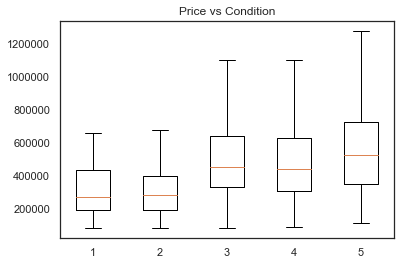

In [856]:
one=df.price[df['condition']==1]
two=df.price[df['condition']==2]
three=df.price[df['condition']==3]
four=df.price[df['condition']==4]
five=df.price[df['condition']==5]
plt.boxplot([one,two,three,four,five],labels=['1','2','3','4','5'],showfliers=False)
plt.title('Price vs Condition')
plt.show()

It looks like the data presents itself in a way to where 2 bins can be constructed where the first bin is [ 1 , 2 ] and the second bin is ( 2 , 5 ]. The next variable that is binned is yr_built. First let's view the distribution of this variable.

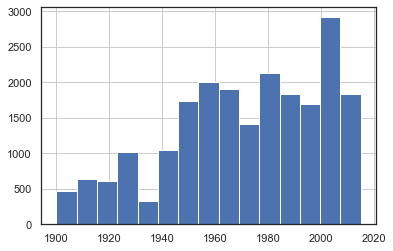

In [857]:
df.yr_built.hist(bins=15)
plt.show()

The information gained from this histogram will be taken into account in addition to accounting for the 3 most significant recessions in the USA during this time span. The first recession taken into account is the Great Depression from 1929-1933. This will be its own bin and everything before the Great Depression will be its own bin as well. From there the next bin will end at the 1973 recession. The 1973 recession is then followed by two significant recession the next 10 years. Thus this period of 3 recessions is binned together. The next bin then starts at 1983 until 1990. From there the selection for the next bin spans from 1990-2000. The bin following that leads up to 2007 in which the Great Recession occurs. This period will be binned by itself from 2007-2009, and a bin from 2009 and on is created after that. 

In [858]:
new_df=df.copy()

bins = [1899,1928,1933,1972,1982 , 1990, 2000, 2007,2009, 2020]
new_age=pd.cut(new_df['yr_built'], bins)
new_age = new_age.cat.as_unordered()

bins_cond=[0,2,5]
cond=pd.cut(new_df['condition'], bins_cond)
cond = cond.cat.as_unordered()



This economic research led to the tangent of deciding whether a separate set of categorial variables are necessary for the year the house was sold. Lets investigate this by use of a scatter plot:

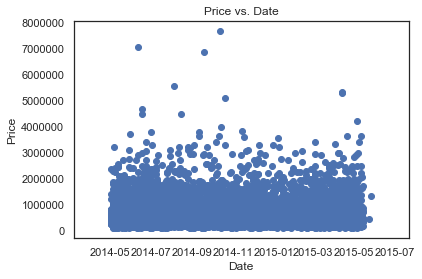

In [859]:
plt.scatter(df.date,df.price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price vs. Date')
plt.show()


There seems to be no real linear pattern in this data thus catergorizing seems unnecessary. After review of the histogram for yr_renovated. Further investigation is needed to see how much of the data has a value of 0 for yr_renovated.

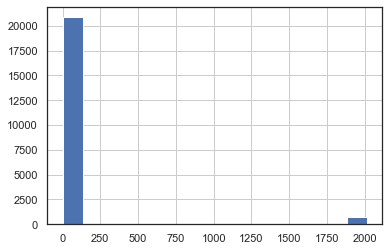

In [860]:
df.yr_renovated.hist(bins=15)

In [861]:
num_zero=(df.yr_renovated==0).sum()
print('Zero is the value for {}% of the data in the column "yr_renovated"'.format(round(num_zero/len(df)*100,2)))

Zero is the value for 96.56% of the data in the column "yr_renovated"


This is a large amount thus the variable yr_renovated can be transformed into a boolean column named "Renovated?" that simply depends on whether the house was renovated or not.

In [862]:
renovated=[]
for val in df.yr_renovated:
    if val == 0:
        renovated.append(False)
    else:
        renovated.append(True)
ren=np.array(renovated)
ren=pd.DataFrame(ren,columns=['Renovated?'])
new_df=pd.concat([new_df,ren],axis=1)

We now can create the categorial variables and incorporate them into the DataFrame. We also can drop the original columns with variables that were categorized.  

In [863]:
cond=pd.get_dummies(cond,prefix='condition')
view=pd.get_dummies(new_df['view'],prefix='view')
waterfront=pd.get_dummies(new_df['waterfront'],prefix='waterfront')
grade=pd.get_dummies(new_df['grade'],prefix='grade')
zipcode=pd.get_dummies(new_df['zipcode'],prefix='zip')
dum_ren=pd.get_dummies(new_df['Renovated?'],prefix='Renovated?')
new_age=pd.get_dummies(new_age,prefix='yr_built')


In [864]:

new_df=pd.concat([new_df,cond,view,waterfront,grade,new_age,dum_ren,zipcode],axis=1)
new_df.drop(['condition','view','waterfront','grade',
             'yr_renovated','Renovated?','zipcode','yr_built'],axis=1,inplace=True)
new_df.head()

id       date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520 2014-10-13  221900.0         3       1.00         1180   
1  6414100192 2014-12-09  538000.0         3       2.25         2570   
2  5631500400 2015-02-25  180000.0         2       1.00          770   
3  2487200875 2014-12-09  604000.0         4       3.00         1960   
4  1954400510 2015-02-18  510000.0         3       2.00         1680   

   sqft_lot  floors  sqft_above  sqft_basement  ...  zip_98146  zip_98148  \
0      5650     1.0        1180              0  ...          0          0   
1      7242     2.0        2170            400  ...          0          0   
2     10000     1.0         770              0  ...          0          0   
3      5000     1.0        1050            910  ...          0          0   
4      8080     1.0        1680              0  ...          0          0   

   zip_98155  zip_98166  zip_98168  zip_98177  zip_98178  zip_98188  \
0          0          0          0          0          1          0   
1          0          0          0          0          0          0   
2          0          0          0          0          0          0   
3          0          0          0          0          0          0   
4          0          0          0          0          0          0   

   zip_98198  zip_98199  
0          0          0  
1          0          0  
2          0          0  
3          0          0  
4          0          0  

[5 rows x 115 columns]

In [865]:
df_cat=df.copy()
df_cat['prime_zipcode'] = df['zipcode'].isin([98039, 98004, 98040, 98112])
prime_zip=pd.get_dummies(df_cat['prime_zipcode'],prefix='prime_zipcode')

## Multicollinearity

Now that all the null values have been either replaced or dropped, the next point of focus is to check for multicollinearity using the seaborn package.


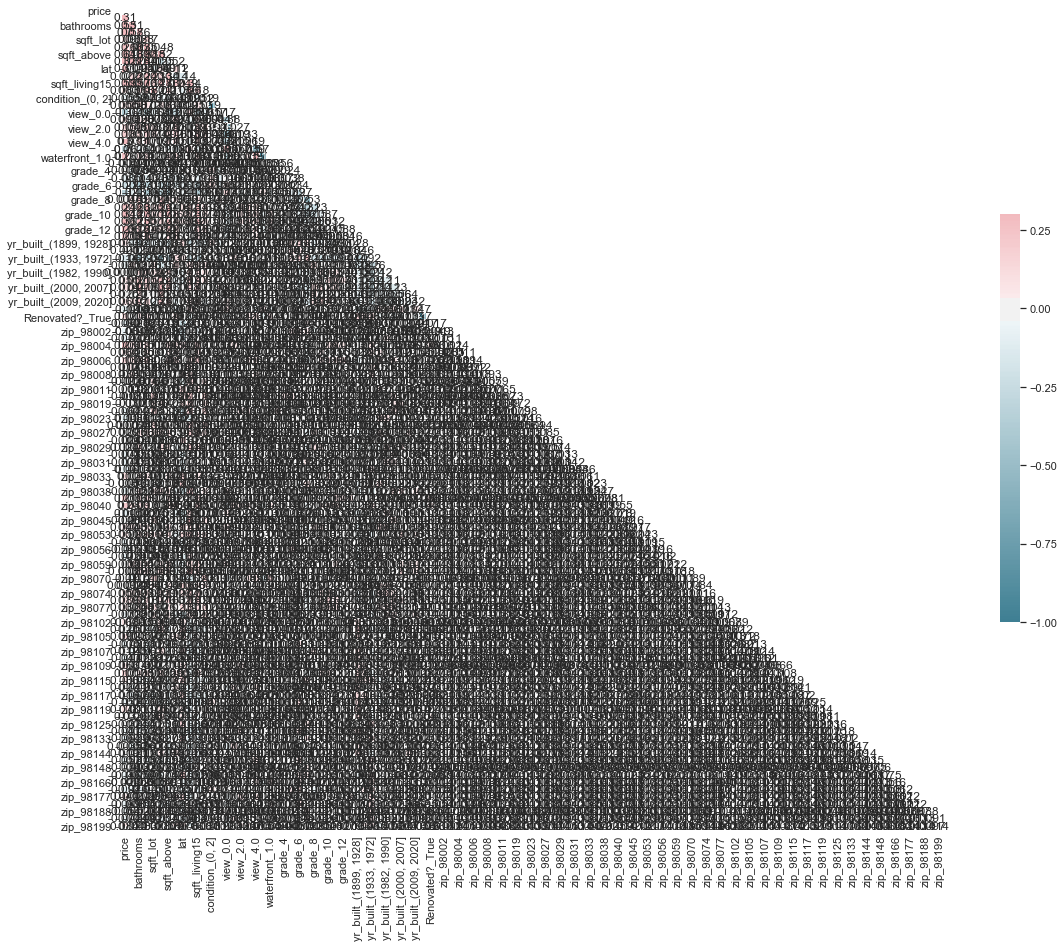

In [867]:
# Set the style of the visualization
sns.set(style="white")

# Create a covariance matrix
corr = new_df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [830]:
abs(df.corr())>.75

id  price  bedrooms  bathrooms  sqft_living  sqft_lot  \
id              True  False     False      False        False     False   
price          False   True     False      False        False     False   
bedrooms       False  False      True      False        False     False   
bathrooms      False  False     False       True         True     False   
sqft_living    False  False     False       True         True     False   
sqft_lot       False  False     False      False        False      True   
floors         False  False     False      False        False     False   
waterfront     False  False     False      False        False     False   
view           False  False     False      False        False     False   
condition      False  False     False      False        False     False   
grade          False  False     False      False         True     False   
sqft_above     False  False     False      False         True     False   
yr_built       False  False     False      False        False     False   
yr_renovated   False  False     False      False        False     False   
zipcode        False  False     False      False        False     False   
lat            False  False     False      False        False     False   
long           False  False     False      False        False     False   
sqft_living15  False  False     False      False         True     False   
sqft_lot15     False  False     False      False        False     False   

               floors  waterfront   view  condition  grade  sqft_above  \
id              False       False  False      False  False       False   
price           False       False  False      False  False       False   
bedrooms        False       False  False      False  False       False   
bathrooms       False       False  False      False  False       False   
sqft_living     False       False  False      False   True        True   
sqft_lot        False       False  False      False  False       False   
floors           True       False  False      False  False       False   
waterfront      False        True  False      False  False       False   
view            False       False   True      False  False       False   
condition       False       False  False       True  False       False   
grade           False       False  False      False   True        True   
sqft_above      False       False  False      False   True        True   
yr_built        False       False  False      False  False       False   
yr_renovated    False       False  False      False  False       False   
zipcode         False       False  False      False  False       False   
lat             False       False  False      False  False       False   
long            False       False  False      False  False       False   
sqft_living15   False       False  False      False  False       False   
sqft_lot15      False       False  False      False  False       False   

               yr_built  yr_renovated  zipcode    lat   long  sqft_living15  \
id                False         False    False  False  False          False   
price             False         False    False  False  False          False   
bedrooms          False         False    False  False  False          False   
bathrooms         False         False    False  False  False          False   
sqft_living       False         False    False  False  False           True   
sqft_lot          False         False    False  False  False          False   
floors            False         False    False  False  False          False   
waterfront        False         False    False  False  False          False   
view              False         False    False  False  False          False   
condition         False         False    False  False  False          False   
grade             False         False    False  False  False          False   
sqft_above        False         False    False  False  False          False   
yr_built 

With a cutoff of 0.75 the following variables have a high correlation:

* sqft_living and sqft_living15 with correlation value of .756
* sqft_living and bathrooms with correlation value of .756
* sqft_living and sqft_above with correlation value of .876
* sqft_living and grade with correlation value of .762
* sqft_above and grade with correlation value of .756

The column sqft_living is dropped as it seems to be the consistent parameter that causes multicollinearity.


In [745]:
df.drop(['sqft_living'],axis=1,inplace=True)

Now we can once again evaluate the heatmap to see if any new correlations above 0.75 come about. 

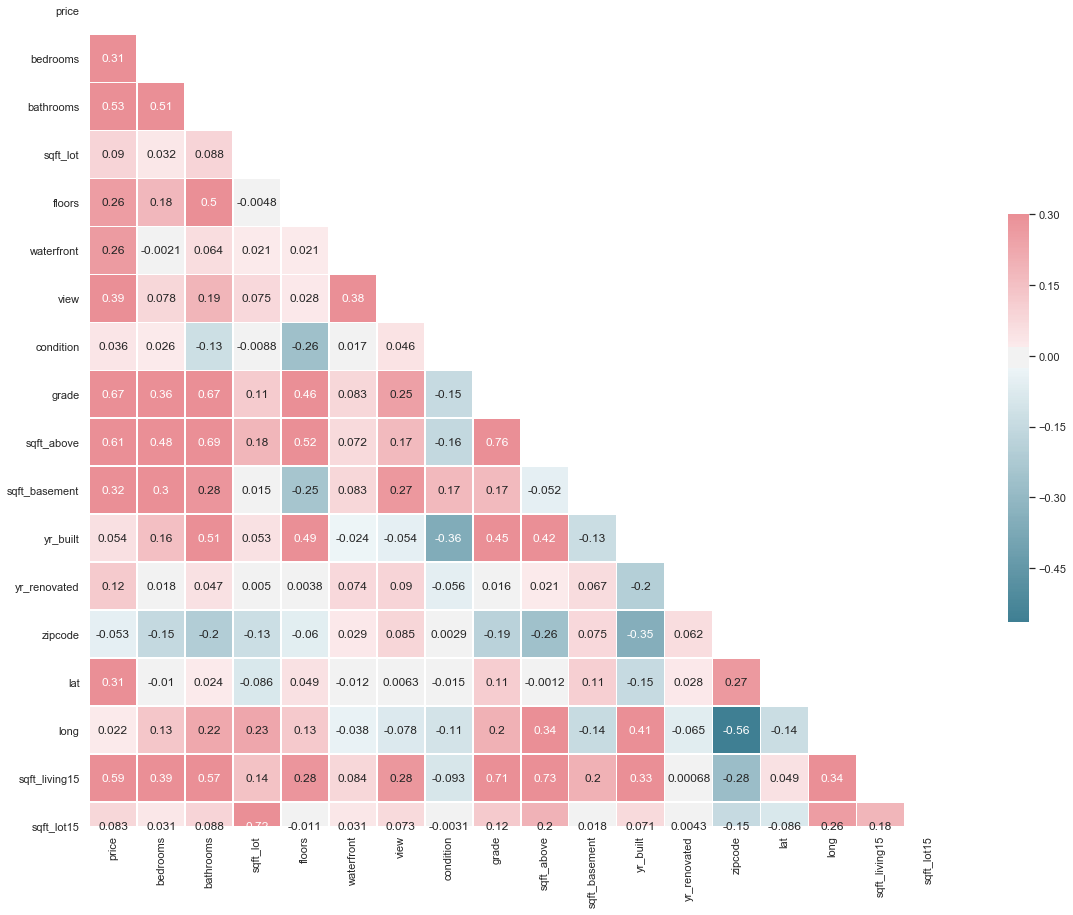

In [720]:
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

We can see that sqft_above and grade still have a correlation above .75. Thus further investigation is needed via a scatter plot to get an idea of this relationship. 

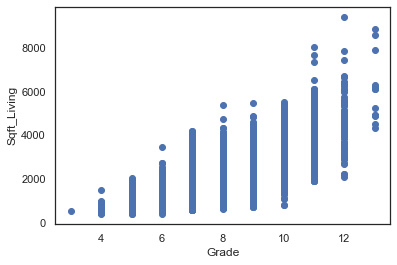

In [746]:
plt.scatter(df.grade,df.sqft_above)
plt.xlabel('Grade')
plt.ylabel('Sqft_Living')
plt.show()

## Normalization and Standardization of Data

To begin the process of normalizing data, we first should evaluate the distribution of each variable.

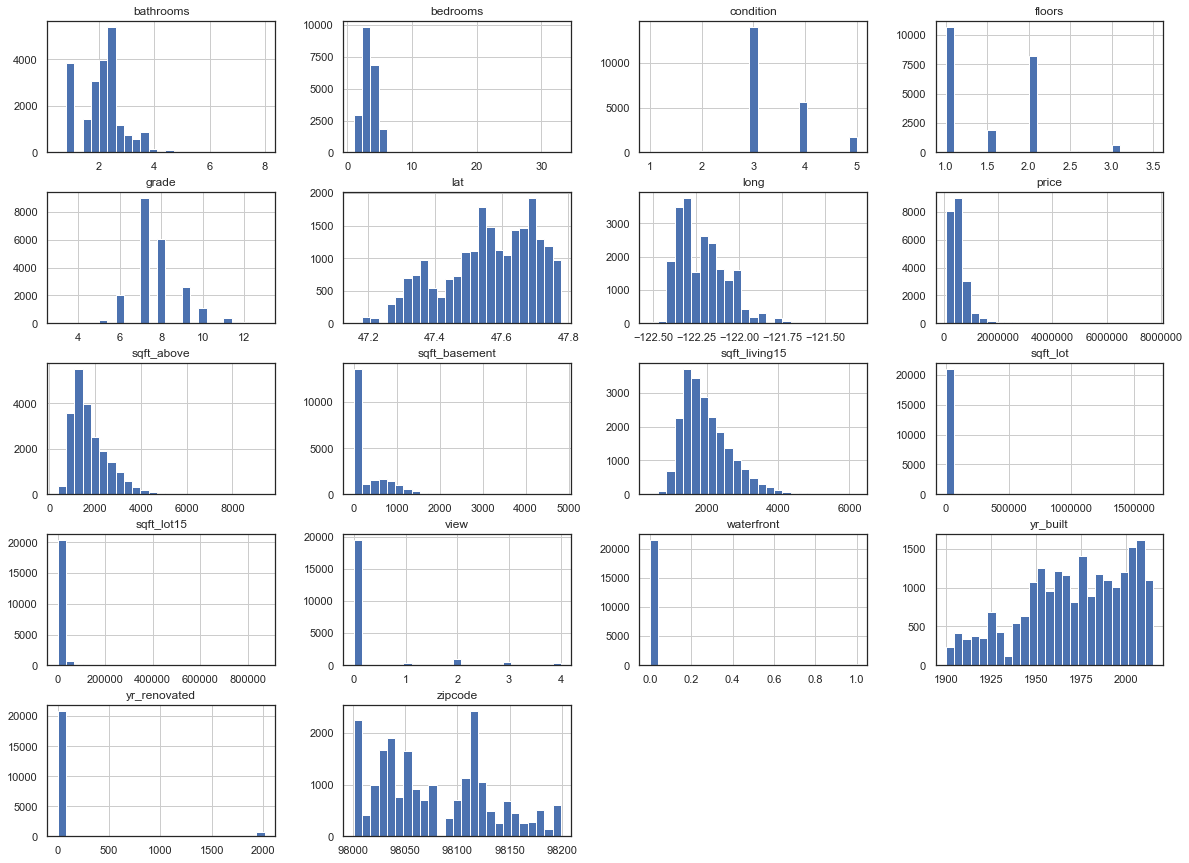

In [748]:
df.hist(figsize=[20,15],bins=25)
plt.show()

From the histograms, one can determine .......

The continuous variables to be normally distributed are:
* sqft_above
* sqft_living15
* sqft_lot
* sqft_lot15
* sqft_basement

These variables were picked in order stay sensitive to outliers. The following features were selected to be min/max scaled:

* floors
* bathrooms
* bedrooms

These variables were min/max scaled in order to scale the values of floors, bathrooms, and bedrooms from 0 to 1. This method of scaling is less senstive to outliers. Thus let's check to see if there are any extreme outliers to verify this decision being less sensitive to them

In [750]:
print('Floors min: {}\nFloors max: {}'.format(df.floors.min(),df.floors.max()))
print('Bathrooms min: {}\nBathrooms max: {}'.format(df.bathrooms.min(),df.bathrooms.max()))
print('Bedrooms min: {}\nBedrooms max: {}'.format(df.bedrooms.min(),df.bedrooms.max()))

Floors min: 1.0
Floors max: 3.5
Bathrooms min: 0.5
Bathrooms max: 8.0
Bedrooms min: 1
Bedrooms max: 33


Thus min/max scaling is selected to stay less sensitive to the extreme outlier of 33 in the bedrooms column

In [751]:
##Save for trial 2
df_save = df.copy()
df.sqft_above=np.log(df.sqft_above)
df.sqft_living15=np.log(df.sqft_living15)
df.sqft_lot=np.log(df.sqft_lot)
df.price=np.log(df.price)
df.sqft_basement=np.log1p(df.sqft_basement)
df.bedrooms=np.log(df.bedrooms)
df.bathrooms=np.log(df.bathrooms)

In [752]:
df.sqft_above=(df.sqft_above-df.sqft_above.mean())/df.sqft_above.std()
df.sqft_living15=(df.sqft_living15-df.sqft_living15.mean())/df.sqft_living15.std()
df.sqft_lot=(df.sqft_lot-df.sqft_lot.mean())/df.sqft_lot.std()
df.sqft_lot15=(df.sqft_lot15-df.sqft_lot15.mean())/df.sqft_lot15.std()
df.sqft_basement=(df.sqft_basement-df.sqft_basement.mean())/df.sqft_basement.std()
df.price=(df.price-df.price.mean())/df.price.std()

df.floors=(df.floors-df.floors.mean())/(df.floors.max()-df.floors.min())
df.bathrooms=(df.bathrooms-df.bathrooms.mean())/(df.bathrooms.max()-df.bathrooms.min())
df.bedrooms=(df.bedrooms-df.bedrooms.mean())/(df.bedrooms.max()-df.bedrooms.min())

After this standardization, the multicollinearity should be checked.

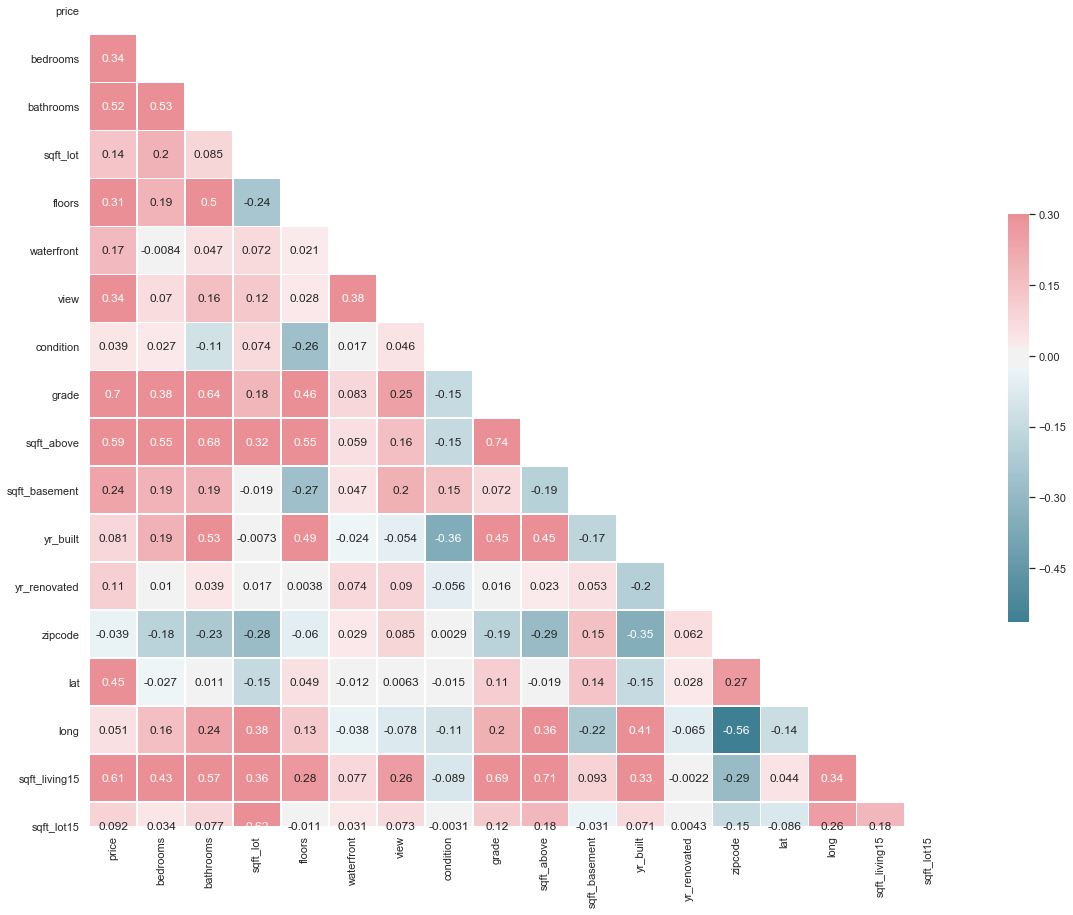

In [753]:
sns.set(style="white")

# Create a covariance matrix
corr = df.corr()

# Generate a mask the size of our covariance matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The scatter plot shows a large amount of variance between the data. This combined with the fact that the correlation value is .756 and it seems to be a catergorial variable makes it not necessary to drop either column. 

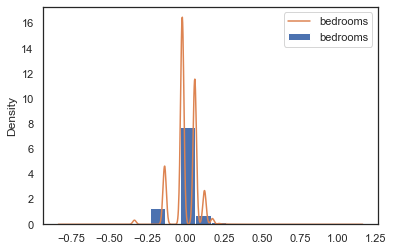

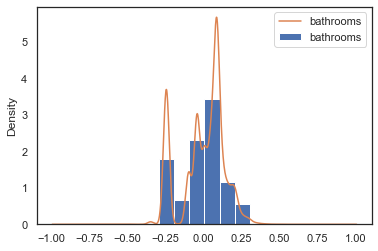

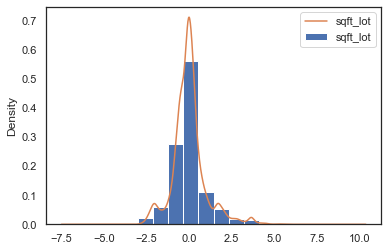

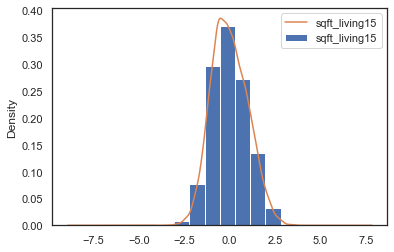

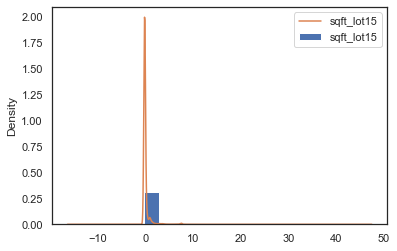

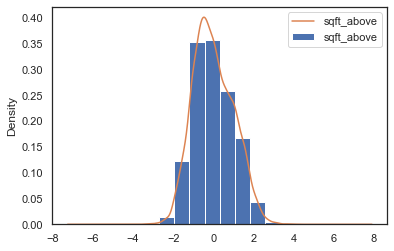

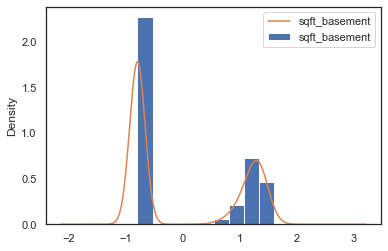

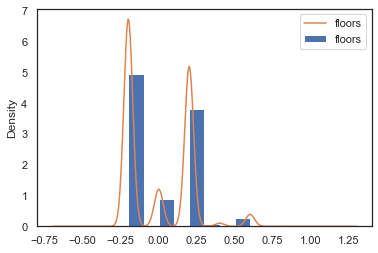

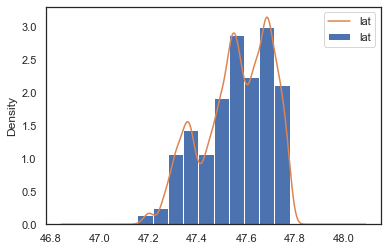

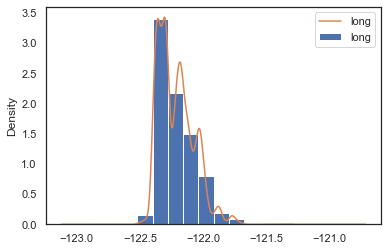

In [375]:
for col in ['bedrooms','bathrooms','sqft_lot','sqft_living15',
            'sqft_lot15','sqft_above','sqft_basement','floors','lat','long']:
    new_df[col].plot.hist(density=True )
    new_df[col].plot.kde(label=col )
    plt.legend()
    plt.show()

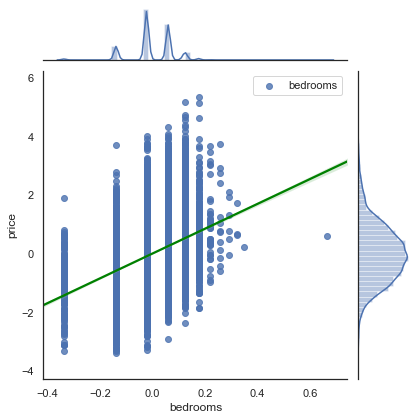

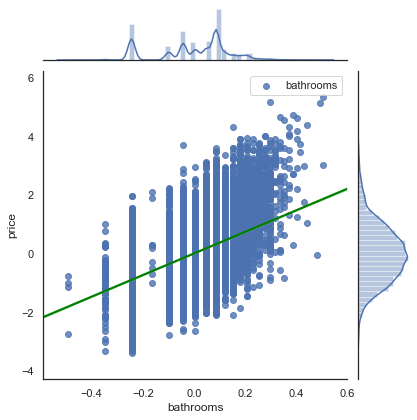

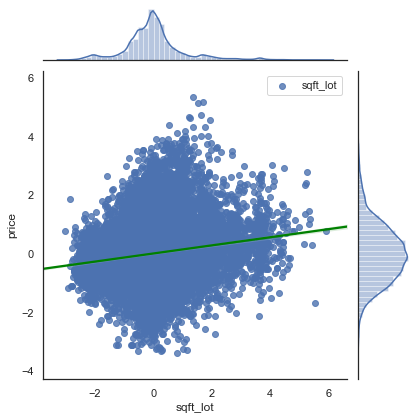

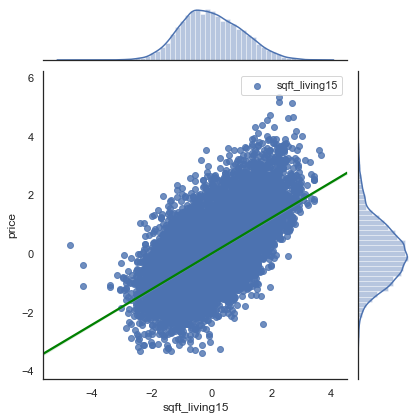

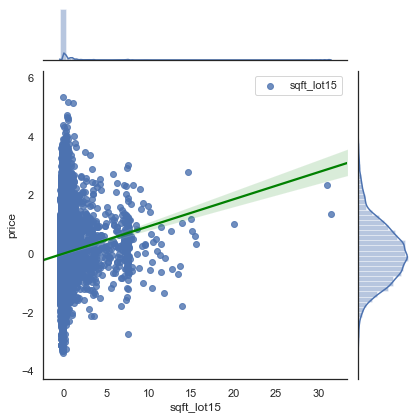

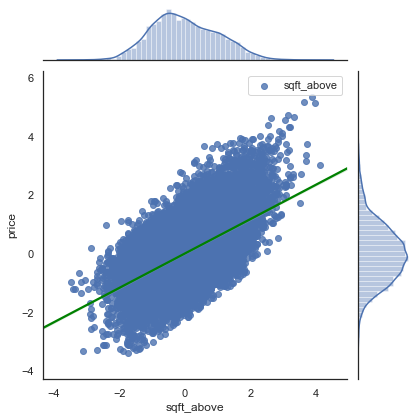

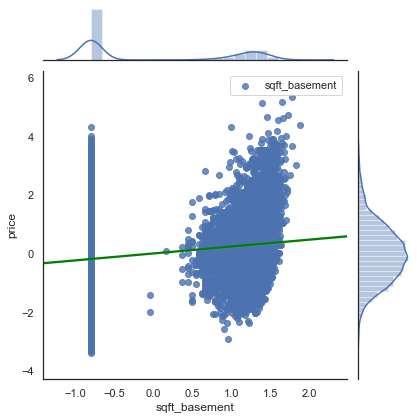

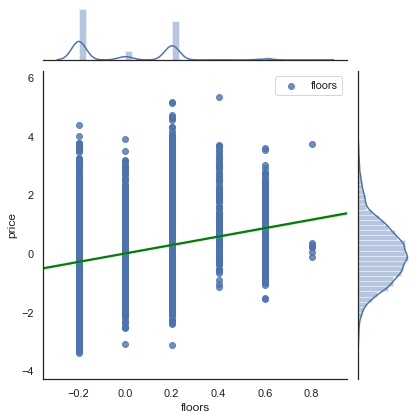

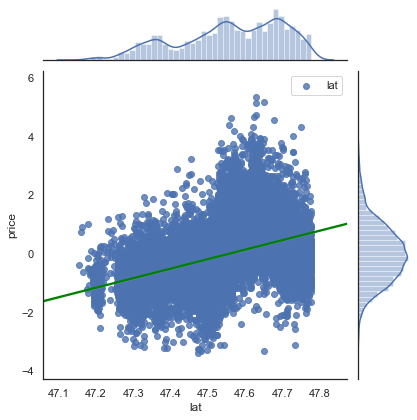

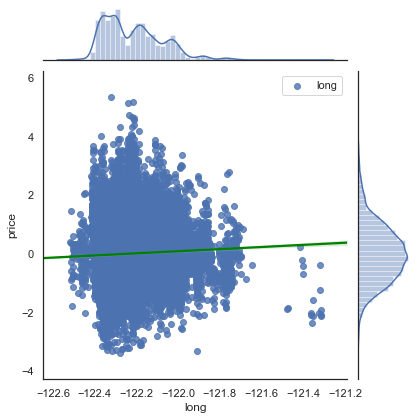

In [376]:
for col in ['bedrooms','bathrooms','sqft_lot','sqft_living15',
            'sqft_lot15','sqft_above','sqft_basement','floors','lat','long']:
    sns.jointplot(x=col, y="price",
                  data=new_df, 
                  kind='reg', 
                  label=col,
                  joint_kws={'line_kws':{'color':'green'}})
#     sns.regplot(walmart[column], walmart.Weekly_Sales, label=column)
    plt.legend()
    plt.show()

In [377]:
df.zipcode.unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

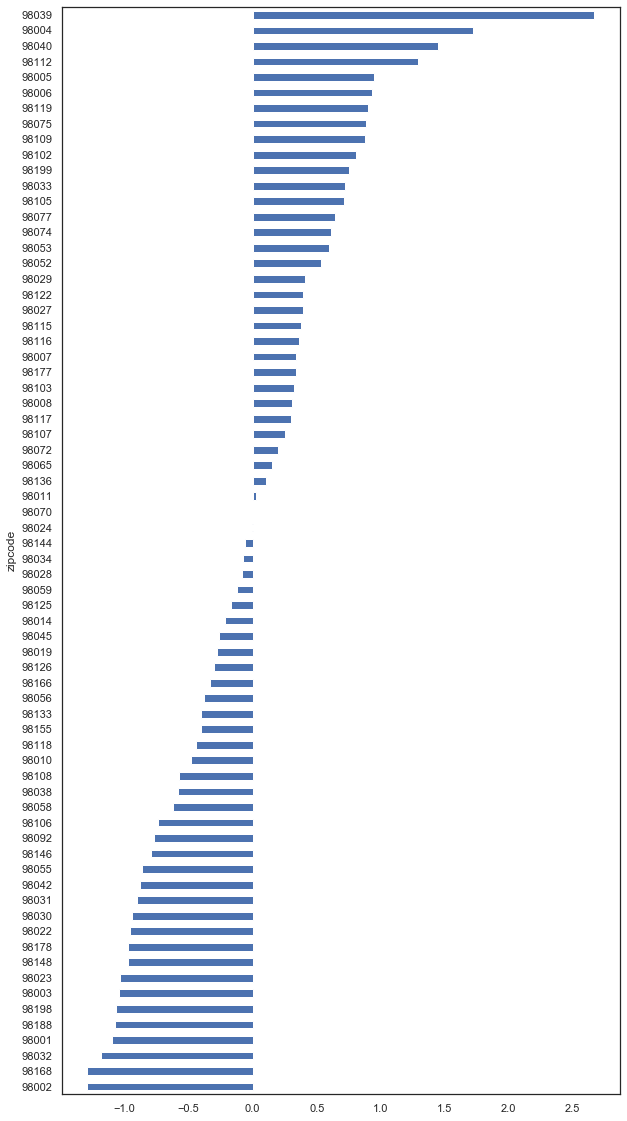

In [378]:
df.groupby('zipcode')['price'].median().sort_values().plot(kind='barh',figsize=(10,20))
plt.show()

In [379]:
top_zipcodes=[98039,98004,98040,98112]

df.groupby(['zipcode']).median()

price  bedrooms  bathrooms  sqft_lot    floors  waterfront  view  \
zipcode                                                                        
98001   -1.101071 -0.022653   0.005599  0.163073 -0.197639         0.0   0.0   
98002   -1.293066 -0.022653  -0.042562 -0.107135 -0.197639         0.0   0.0   
98003   -1.047244 -0.022653   0.005599  0.104779 -0.197639         0.0   0.0   
98004    1.722635  0.059624   0.086081  0.362060 -0.197639         0.0   0.0   
98005    0.949632  0.059624   0.067081  0.466726 -0.197639         0.0   0.0   
...           ...       ...        ...       ...       ...         ...   ...   
98177    0.335595 -0.022653   0.005599  0.025833 -0.197639         0.0   0.0   
98178   -0.972058 -0.022653  -0.042562 -0.119689 -0.197639         0.0   0.0   
98188   -1.072089 -0.022653  -0.042562  0.116909 -0.197639         0.0   0.0   
98198   -1.064895 -0.022653  -0.042562  0.075914 -0.197639         0.0   0.0   
98199    0.751956 -0.022653   0.005599 -0.418258 -0.197639         0.0   0.0   

         condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
zipcode                                                                        
98001          3.0    7.0   -0.040710      -0.798211    1981.0           0.0   
98002          4.0    7.0   -0.287375      -0.798211    1966.0           0.0   
98003          3.0    7.0   -0.223284      -0.798211    1975.0           0.0   
98004          3.0    9.0    0.629136      -0.798211    1965.0           0.0   
98005          4.0    8.0    0.434374       1.006697    1967.0           0.0   
...            ...    ...         ...            ...       ...           ...   
98177          3.0    8.0    0.002780       1.092003    1956.0           0.0   
98178          3.0    7.0   -0.714217      -0.798211    1952.0           0.0   
98188          3.0    7.0   -0.438470      -0.798211    1959.5           0.0   
98198          3.0    7.0   -0.474293      -0.798211    1962.0           0.0   
98199          3.0    8.0   -0.421192       1.162214    1948.0           0.0   

              lat      long  sqft_living15  sqft_lot15  
zipcode                                                 
98001    47.31620 -122.2720      -0.308765   -0.140288  
98002    47.30630 -122.2150      -0.879932   -0.199538  
98003    47.32870 -122.3080      -0.178667   -0.152846  
98004    47.62140 -122.2050       0.917422   -0.050644  
98005    47.60335 -122.1685       0.788494   -0.041606  
...           ...       ...            ...         ...  
98177    47.75370 -122.3680       0.351025   -0.165000  
98178    47.49915 -122.2465      -0.399928   -0.203791  
98188    47.44815 -122.2820      -0.513043   -0.124174  
98198    47.39225 -122.3170      -0.437169   -0.169473  
98199    47.64800 -122.3980      -0.117300   -0.265387  

[70 rows x 17 columns]

In [380]:
zp.columns

NameError: name 'zp' is not defined

# 4. Modeling 

To start the modeling process, let's drop the columns id and date as they present to value to the model. 

## Trial 1: Initial Model

* Categorial predictors: view, waterfront, grade, condition, yr_built, renovated,zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_basement, sqft_living15, sqft_living
* Notes: initial model

In [764]:
testing=new_df.copy()
testing.drop(['id','date'],axis=1,inplace=True)
x=testing.drop(['price',],axis=1)
y=testing.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [765]:
x_train.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
3902   0.059624   0.180709  1.724860  0.202361    1.661176       0.990889   
17608 -0.022653  -0.098160 -0.459320 -0.197639   -0.875740       1.416190   
1009   0.059624  -0.042562 -0.418258  0.002361   -1.026835       1.268142   
14026  0.059624  -0.042562 -0.299849 -0.197639   -0.455876       1.472700   
17575  0.059624  -0.244401 -0.368403  0.002361    0.410393      -0.798211   

           lat     long  sqft_living15  sqft_lot15  ...  zip_98146  zip_98148  \
3902   47.7124 -122.253       0.794765    0.364250  ...          0          0   
17608  47.6927 -122.395      -0.237744   -0.207091  ...          0          0   
1009   47.6802 -122.388      -0.418492   -0.266120  ...          0          0   
14026  47.6965 -122.393       0.640762   -0.216990  ...          0          0   
17575  47.7188 -122.358       0.436650   -0.245038  ...          0          0   

       zip_98155  zip_98166  zip_98168  zip_98177  zip_98178  zip_98188  \
3902           0          0          0          0          0          0   
17608          0          0          0          0          0          0   
1009           0          0          0          0          0          0   
14026          0          0          0          0          0          0   
17575          0          0          0          1          0          0   

       zip_98198  zip_98199  
3902           0          0  
17608          0          0  
1009           0          0  
14026          0          0  
17575          0          0  

[5 rows x 111 columns]

In [766]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1274.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:04:49   Log-Likelihood:                -5837.5
No. Observations:               17277   AIC:                         1.188e+04
Df Residuals:                   17172   BIC:                         1.270e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -53.1405      5.119    -10.382      0.000     -63.174     -43.107
bedrooms                 -0.1124      0.045     -2.522      0.012      -0.200      -0.025
bathrooms                 0.4640      0.034     13.694      0.000       0.398       0.530
sqft_lot                  0.1421      0.005     27.529      0.000       0.132       0.152
floors                   -0.1924      0.021     -9.202      0.000      -0.233      -0.151
sqft_above                0.3185      0.006     49.204      0.000       0.306       0.331
sqft_basement             0.1132      0.004     30.343      0.000       0.106       0.120
lat                       0.9266      0.150      6.161      0.000       0.632       1.221
long                     -0.9139      0.112     -8.171      0.000      -1.133      -0.695
sqft_living15             0.0842      0.005     18.405      0.000       0.075       0.093
sqft_lot15               -0.0131      0.004     -3.487      0.000      -0.020      -0.006
condition_(0, 2]        -26.7591      2.559    -10.455      0.000     -31.776     -21.742
condition_(2, 5]        -26.3814      2.559    -10.308      0.000     -31.398     -21.365
view_0.0                -10.9052      1.024    -10.652      0.000     -12.912      -8.899
view_1.0                -10.6752      1.024    -10.426      0.000     -12.682      -8.668
view_2.0                -10.7002      1.024    -10.452      0.000     -12.707      -8.693
view_3.0                -10.5608      1.024    -10.316      0.000     -12.567      -8.554
view_4.0                -10.2991      1.024    -10.056      0.000     -12.307      -8.292
waterfront_0.0          -26.9633      2.559    -10.536      0.000     -31.980     -21.947
waterfront_1.0          -26.1772      2.560    -10.227      0.000     -31.194     -21.160
grade_3                  -4.3572      0.560     -7.783      0.000      -5.455      -3.260
grade_4                  -5.6107      0.471    -11.910      0.000      -6.534      -4.687
grade_5                  -5.4991      0.466    -11.796      0.000      -6.413      -4.585
grade_6                  -5.3353      0.467    -11.435      0.000      -6.250      -4.421
grade_7                  -5.2098      0.467    -11.164      0.000      -6.124      -4.295
grade_8                  -5.0631      0.467    -10.845      0.000      -5.978      -4.148
grade_9                  -4.8505      0.467    -10.391      0.000      -5.765      -3.936
grade_10                 -4.6852      0.467    -10.034      0.000      -5.600      -3.770
grade_11                 -4.4707      0.468     -9.562      0.000      -5.387      -3.554
grade_12                 -4.2200      0.468     -9.018      0.000      -5.137      -3.303
grade_13                 -3.8391      0.478     -8.039      0.000      -4.775      -2.903
yr_built_(1899, 1928]  

In [767]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [768]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.11508032651771312
Test Mean Squarred Error: 0.12147728456855336


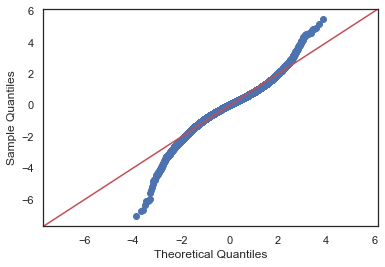

In [769]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

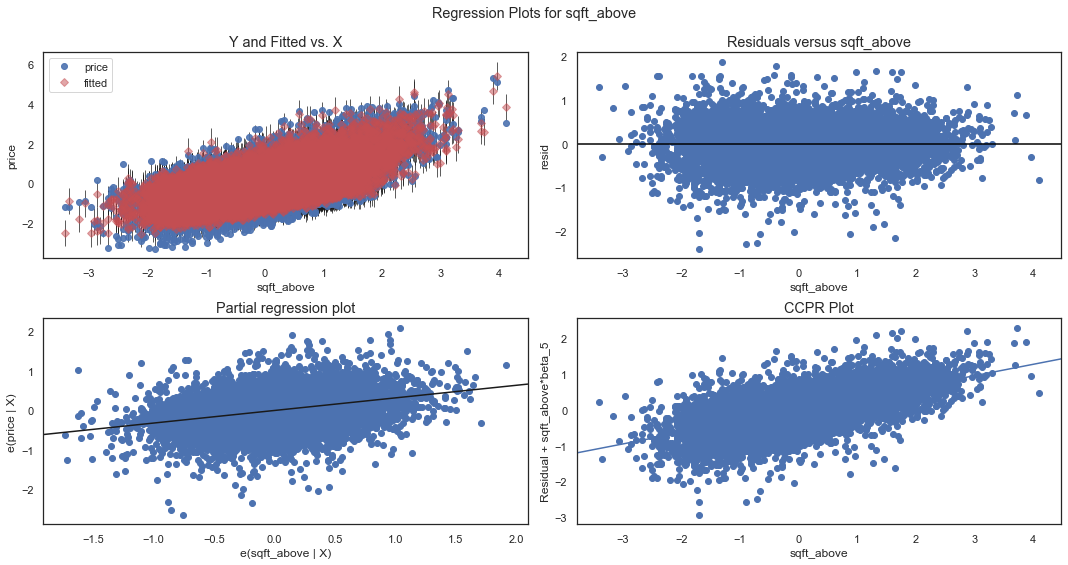

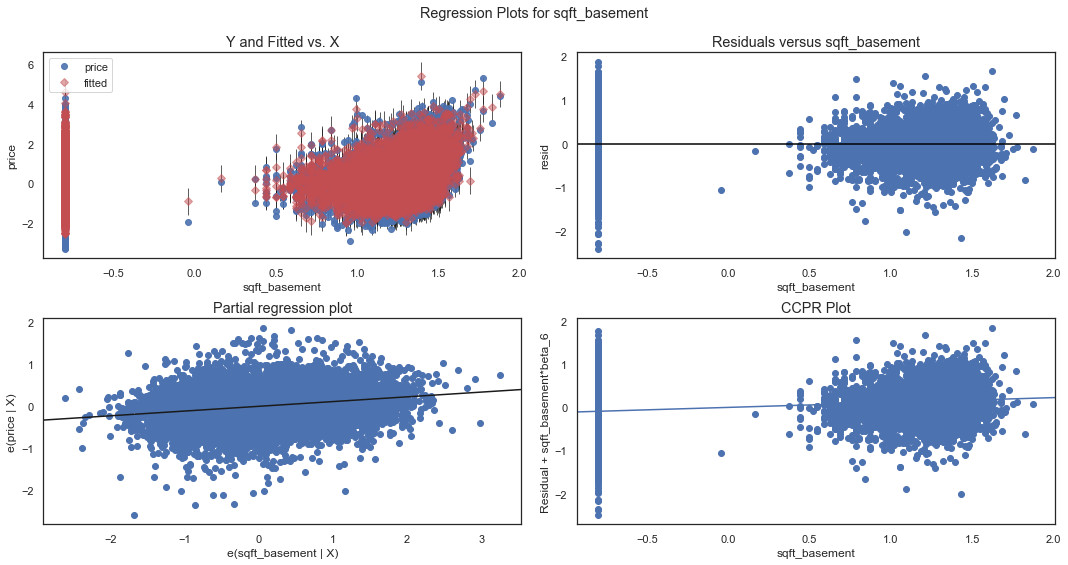

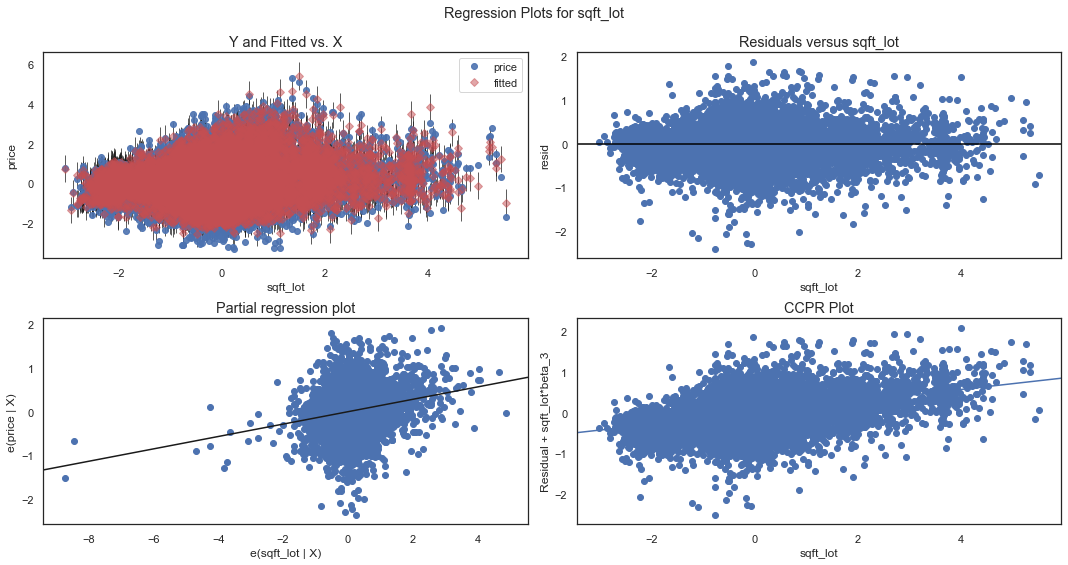

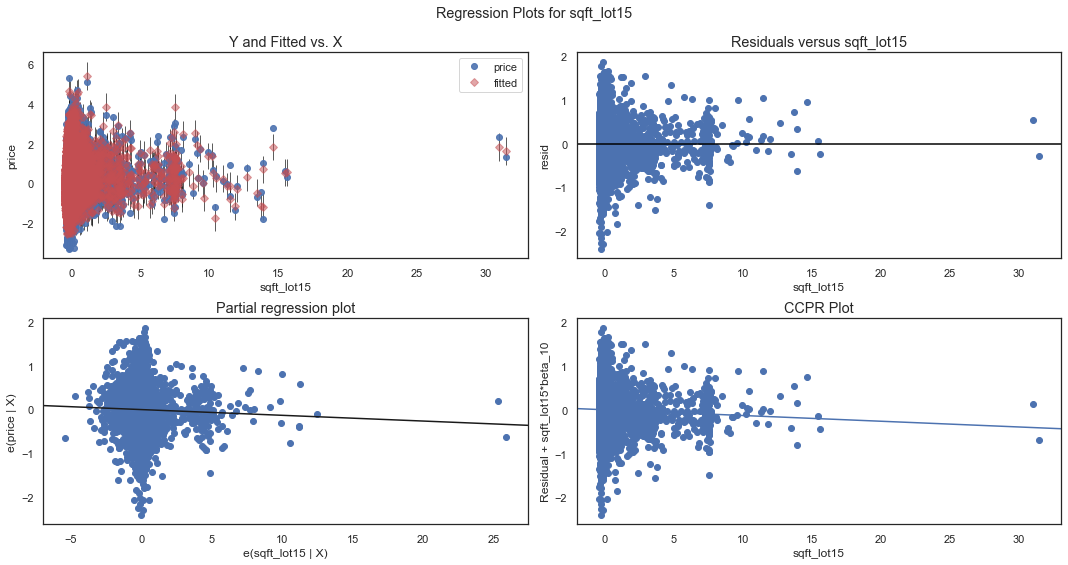

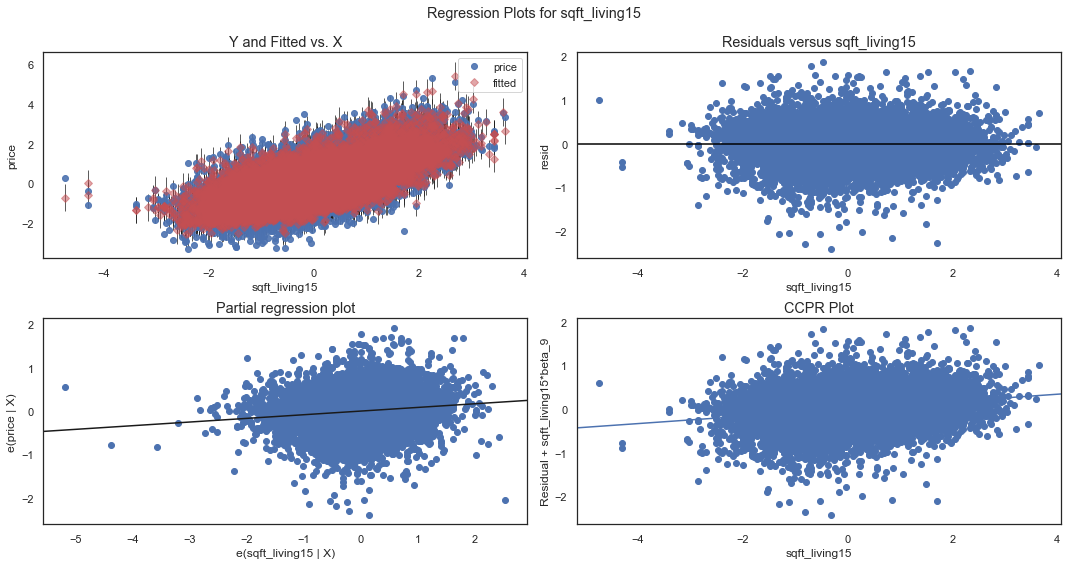

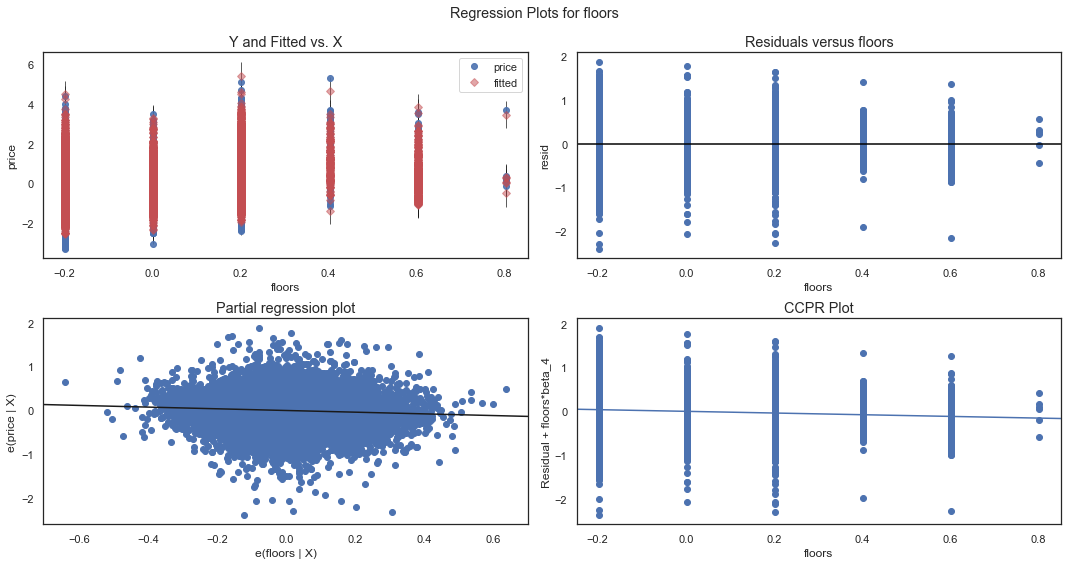

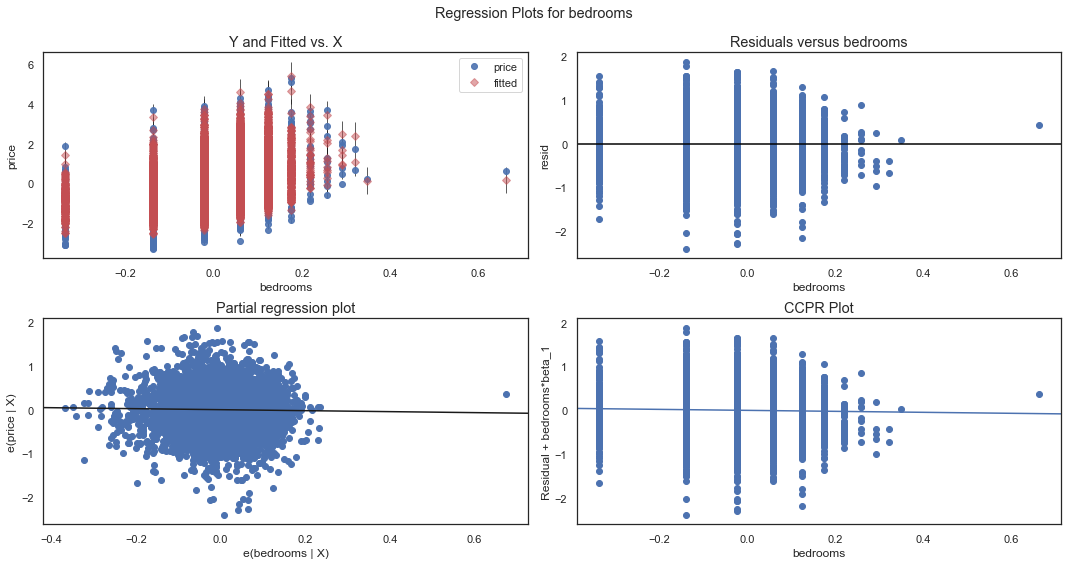

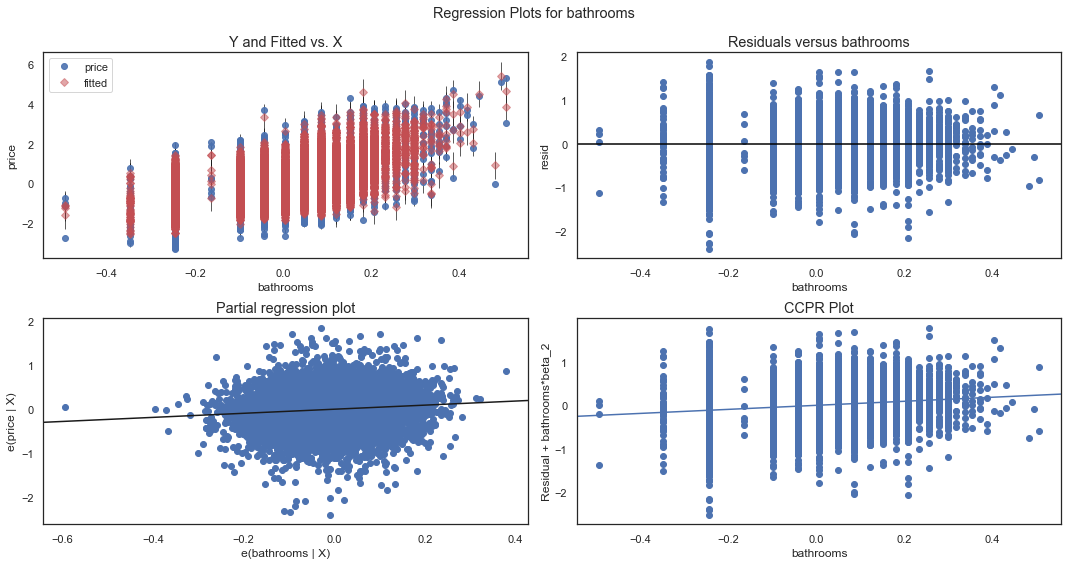

In [770]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_basement','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [771]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 5748.329521639357),
 ('Prob', 0.0),
 ('Skew', -0.2840269508497401),
 ('Kurtosis', 5.768120677020321)]

### Trial 1 Discussion
The R squared value is good but the Jarque-Bera value is too high and this along with the residuals plot indicates that normality is still an issue. In addition, the kurtosis and skew values are too high. Let's try to attack this by peforming a log transformation on the continuous variables and then running a model. 

## Trial 2: Log Transformation of Continuous Variables 

* Categorial predictors: view, waterfront, grade, condition (binned), yr_built (binned), renovated,zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_basement, sqft_living15, sqft_living
* Notes: log transformed sqft_above, sqft_living15, sqft_lot, price, and sqft_basement

Below one can see the variables that were normalized. Note that sqft_basement has many entries with the value of zero thus the log1p function is used which for every x returns log(x+1). Once the variables were normalized, the process is very similar to trial 1. 

In [639]:
## Do not run this code. This was here to simply show the process behind normalization.
df.sqft_above=np.log(df.sqft_above)
df.sqft_living15=np.log(df.sqft_living15)
df.sqft_lot=np.log(df.sqft_lot)
df.price=np.log(df.price)
df.sqft_basement=np.log1p(df.sqft_basement)

IndentationError: unexpected indent (<ipython-input-639-d8d9742f752d>, line 2)

In [ ]:

df.sqft_above=(df.sqft_above-df.sqft_above.mean())/df.sqft_above.std()
df.sqft_living15=(df.sqft_living15-df.sqft_living15.mean())/df.sqft_living15.std()
df.sqft_lot=(df.sqft_lot-df.sqft_lot.mean())/df.sqft_lot.std()
df.sqft_lot15=(df.sqft_lot15-df.sqft_lot15.mean())/df.sqft_lot15.std()
df.sqft_basement=(df.sqft_basement-df.sqft_basement.mean())/df.sqft_basement.std()
df.price=(df.price-df.price.mean())/df.price.std()

df.floors=(df.floors-df.floors.mean())/(df.floors.max()-df.floors.min())
df.bathrooms=(df.bathrooms-df.bathrooms.mean())/(df.bathrooms.max()-df.bathrooms.min())
df.bedrooms=(df.bedrooms-df.bedrooms.mean())/(df.bedrooms.max()-df.bedrooms.min())

In [772]:
testing2=new_df.copy()
x=testing2.drop(['id','date','price'],axis=1)
y=testing2.price

In [773]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [774]:
x_train.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
3902   0.059624   0.180709  1.724860  0.202361    1.661176       0.990889   
17608 -0.022653  -0.098160 -0.459320 -0.197639   -0.875740       1.416190   
1009   0.059624  -0.042562 -0.418258  0.002361   -1.026835       1.268142   
14026  0.059624  -0.042562 -0.299849 -0.197639   -0.455876       1.472700   
17575  0.059624  -0.244401 -0.368403  0.002361    0.410393      -0.798211   

           lat     long  sqft_living15  sqft_lot15  ...  zip_98146  zip_98148  \
3902   47.7124 -122.253       0.794765    0.364250  ...          0          0   
17608  47.6927 -122.395      -0.237744   -0.207091  ...          0          0   
1009   47.6802 -122.388      -0.418492   -0.266120  ...          0          0   
14026  47.6965 -122.393       0.640762   -0.216990  ...          0          0   
17575  47.7188 -122.358       0.436650   -0.245038  ...          0          0   

       zip_98155  zip_98166  zip_98168  zip_98177  zip_98178  zip_98188  \
3902           0          0          0          0          0          0   
17608          0          0          0          0          0          0   
1009           0          0          0          0          0          0   
14026          0          0          0          0          0          0   
17575          0          0          0          1          0          0   

       zip_98198  zip_98199  
3902           0          0  
17608          0          0  
1009           0          0  
14026          0          0  
17575          0          0  

[5 rows x 111 columns]

In [775]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1274.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:05:05   Log-Likelihood:                -5837.5
No. Observations:               17277   AIC:                         1.188e+04
Df Residuals:                   17172   BIC:                         1.270e+04
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -53.1405      5.119    -10.382      0.000     -63.174     -43.107
bedrooms                 -0.1124      0.045     -2.522      0.012      -0.200      -0.025
bathrooms                 0.4640      0.034     13.694      0.000       0.398       0.530
sqft_lot                  0.1421      0.005     27.529      0.000       0.132       0.152
floors                   -0.1924      0.021     -9.202      0.000      -0.233      -0.151
sqft_above                0.3185      0.006     49.204      0.000       0.306       0.331
sqft_basement             0.1132      0.004     30.343      0.000       0.106       0.120
lat                       0.9266      0.150      6.161      0.000       0.632       1.221
long                     -0.9139      0.112     -8.171      0.000      -1.133      -0.695
sqft_living15             0.0842      0.005     18.405      0.000       0.075       0.093
sqft_lot15               -0.0131      0.004     -3.487      0.000      -0.020      -0.006
condition_(0, 2]        -26.7591      2.559    -10.455      0.000     -31.776     -21.742
condition_(2, 5]        -26.3814      2.559    -10.308      0.000     -31.398     -21.365
view_0.0                -10.9052      1.024    -10.652      0.000     -12.912      -8.899
view_1.0                -10.6752      1.024    -10.426      0.000     -12.682      -8.668
view_2.0                -10.7002      1.024    -10.452      0.000     -12.707      -8.693
view_3.0                -10.5608      1.024    -10.316      0.000     -12.567      -8.554
view_4.0                -10.2991      1.024    -10.056      0.000     -12.307      -8.292
waterfront_0.0          -26.9633      2.559    -10.536      0.000     -31.980     -21.947
waterfront_1.0          -26.1772      2.560    -10.227      0.000     -31.194     -21.160
grade_3                  -4.3572      0.560     -7.783      0.000      -5.455      -3.260
grade_4                  -5.6107      0.471    -11.910      0.000      -6.534      -4.687
grade_5                  -5.4991      0.466    -11.796      0.000      -6.413      -4.585
grade_6                  -5.3353      0.467    -11.435      0.000      -6.250      -4.421
grade_7                  -5.2098      0.467    -11.164      0.000      -6.124      -4.295
grade_8                  -5.0631      0.467    -10.845      0.000      -5.978      -4.148
grade_9                  -4.8505      0.467    -10.391      0.000      -5.765      -3.936
grade_10                 -4.6852      0.467    -10.034      0.000      -5.600      -3.770
grade_11                 -4.4707      0.468     -9.562      0.000      -5.387      -3.554
grade_12                 -4.2200      0.468     -9.018      0.000      -5.137      -3.303
grade_13                 -3.8391      0.478     -8.039      0.000      -4.775      -2.903
yr_built_(1899, 1928]  

In [776]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [777]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.11508032651771312
Test Mean Squarred Error: 0.12147728456855336


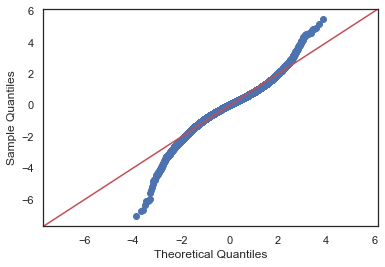

In [778]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

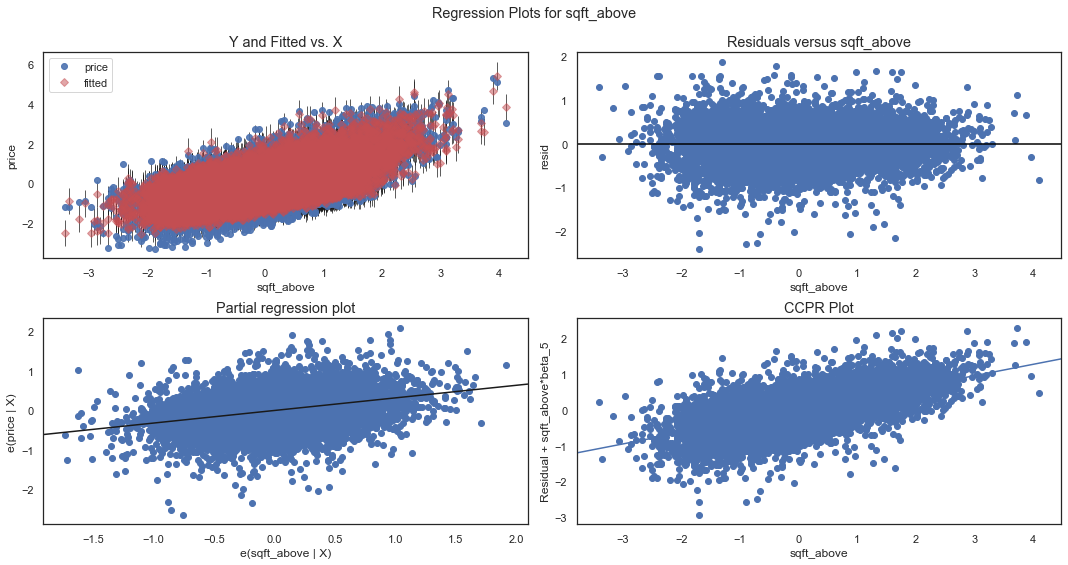

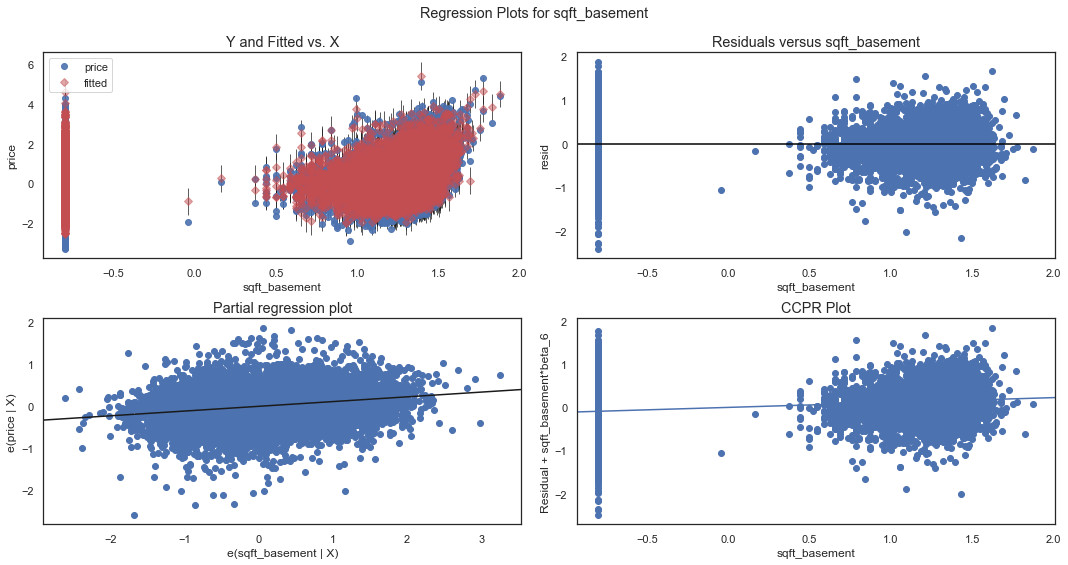

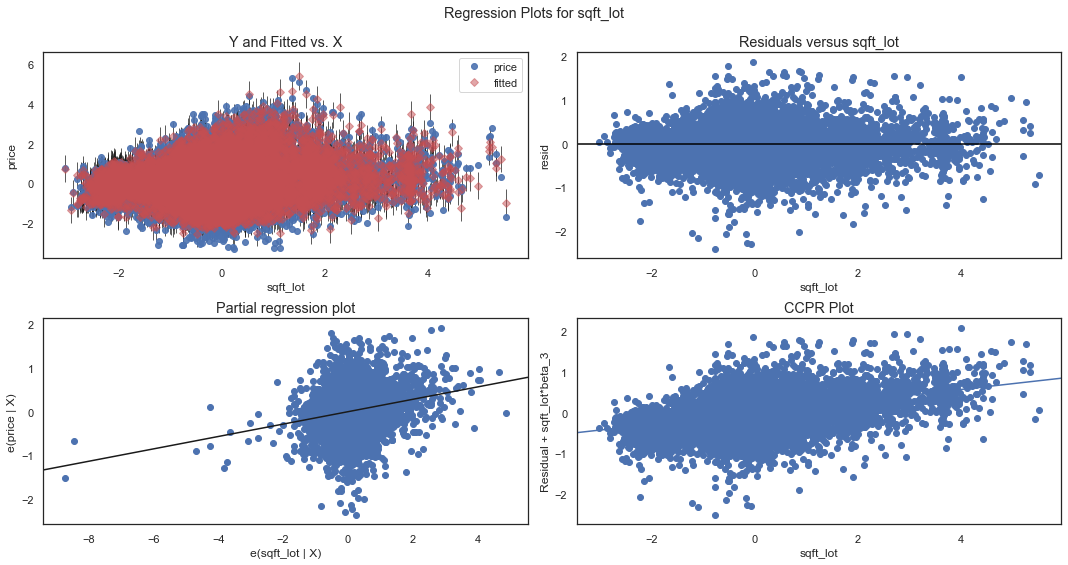

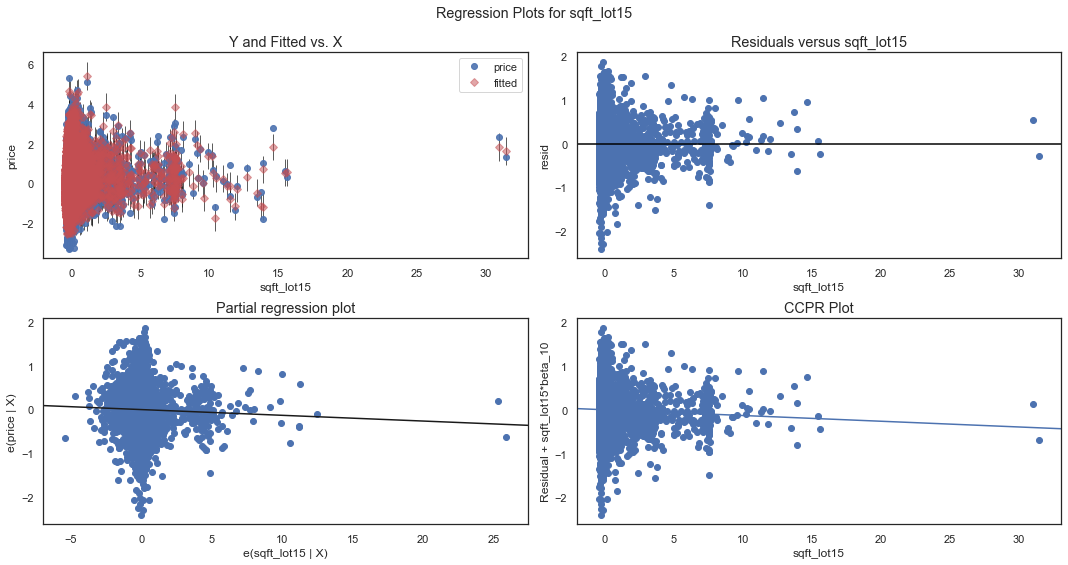

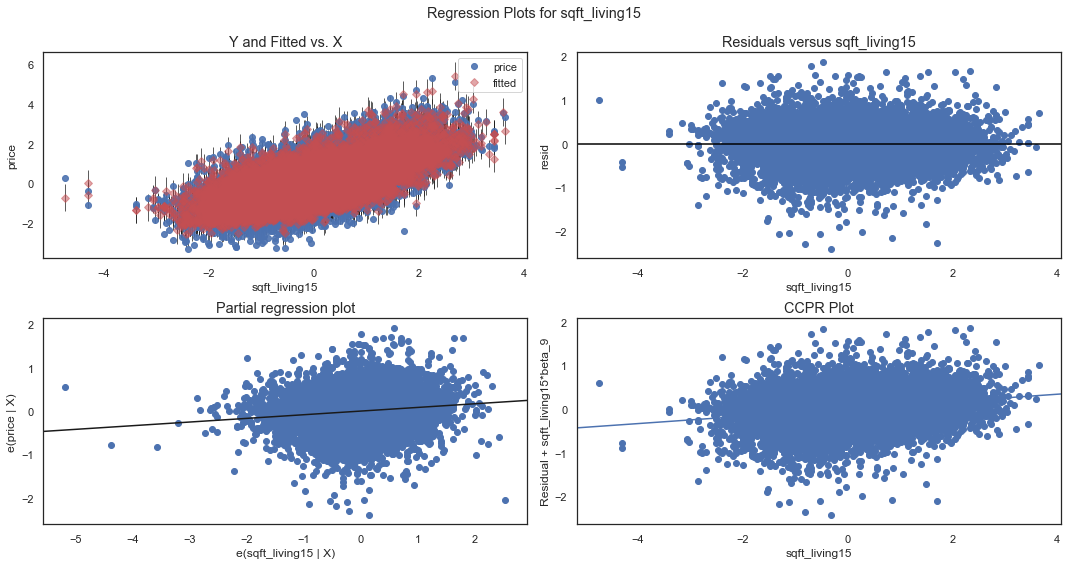

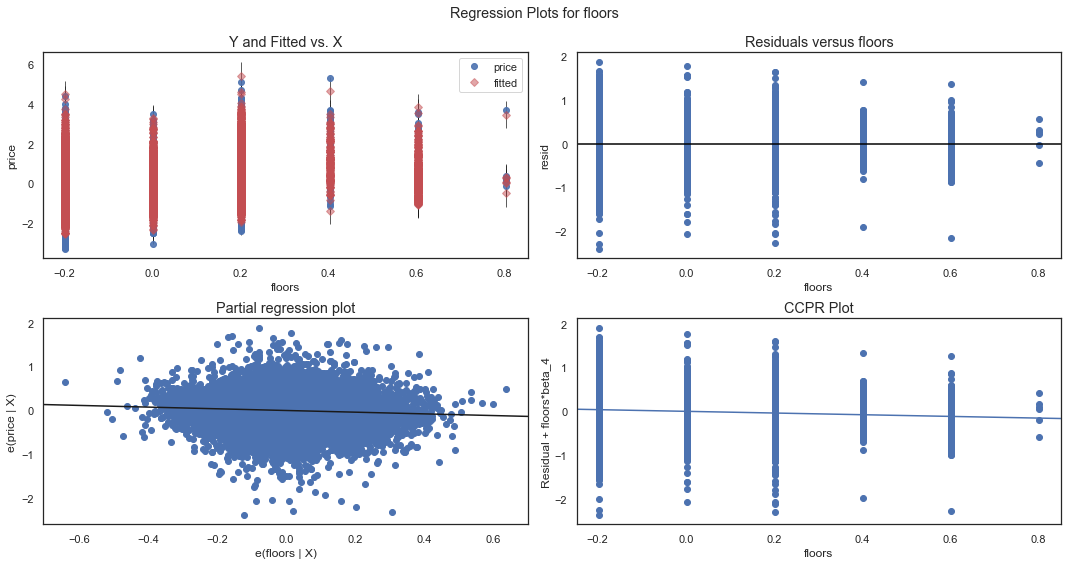

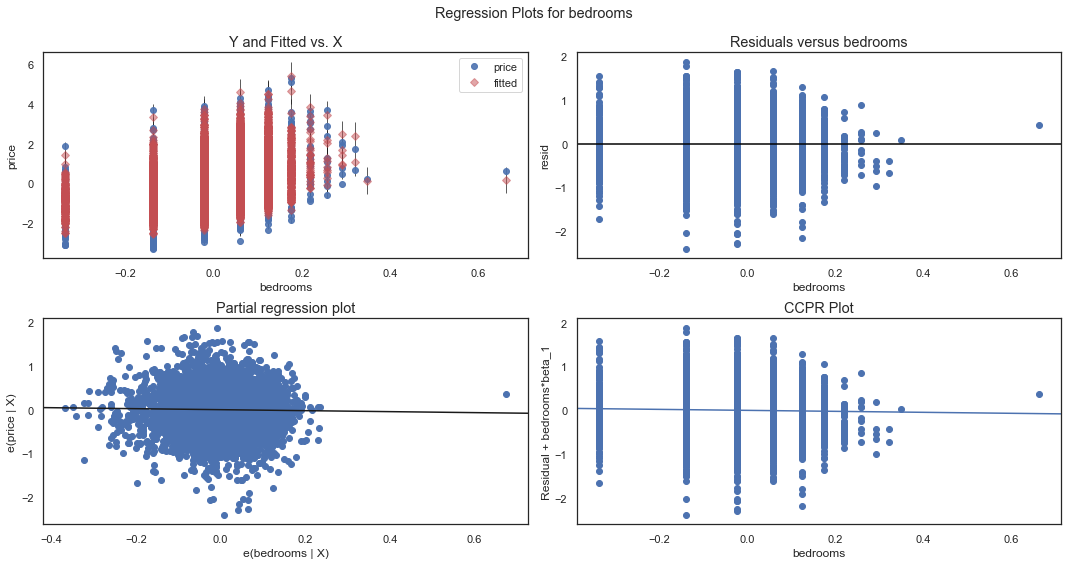

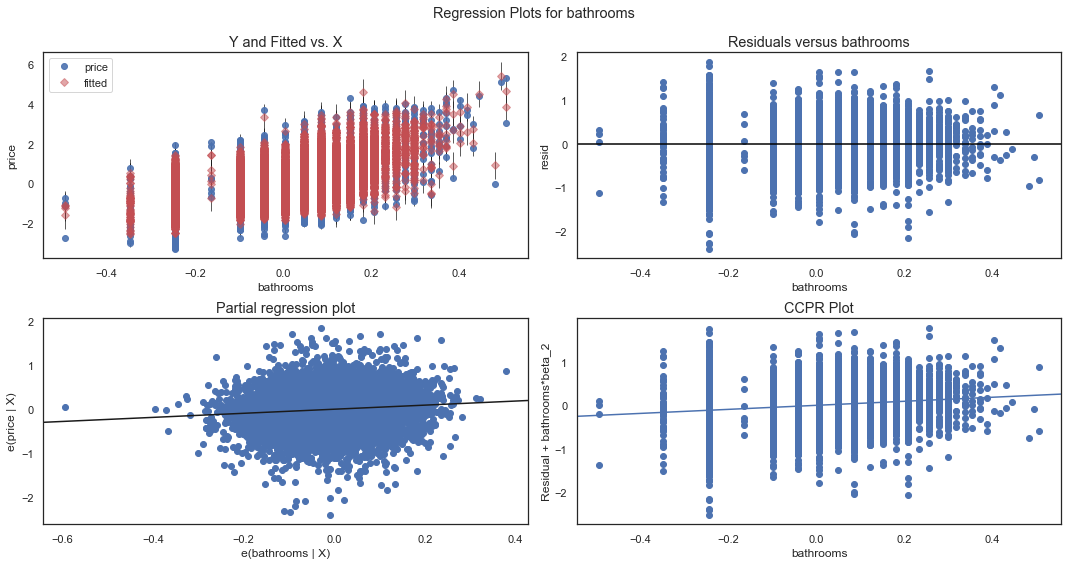

In [779]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_basement','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [780]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 5748.329521639357),
 ('Prob', 0.0),
 ('Skew', -0.2840269508497401),
 ('Kurtosis', 5.768120677020321)]

### Trial 2 Discussion:
The R squared value increased and the residual plots seem to improve when it comes to normality. This is also evident by the decrease in the Jarque-Bera value. In addition the skew and kurtosis have decreased. Thus log transformation seems to be beneficial in improving the model and its results. The next point of focus is to eliminate outliers and see if this improves the model. 

## Trial 3: Eliminating Outliers

* Categorial predictors: view, waterfront, grade, condition (binned), yr_built (binned), renovated,zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_basement, sqft_living15, sqft_living
* Notes: log transformed sqft_above, sqft_living15, sqft_lot, price, and sqft_basement. Eliminated outliers 


The process of eliminating outliers for the continous variables consisted of simple eliminating any data point that had a Z score of over 3. This is done first by calculating the Z score as seen below.

In [781]:
df2['zsqft_above']=(df2.sqft_above-df2.sqft_above.mean())/df2.sqft_above.std()
df2['zsqft_living15']=(df2.sqft_living15-df2.sqft_living15.mean())/df2.sqft_living15.std()
df2['zsqft_lot']=(df2.sqft_lot-df2.sqft_lot.mean())/df2.sqft_lot.std()
df2['zsqft_lot15']=(df2.sqft_lot15-df2.sqft_lot15.mean())/df2.sqft_lot15.std()
df2['zsqft_basement']=(df2.sqft_basement-df2.sqft_basement.mean())/df2.sqft_basement.std()
df2['zprice']=(df2.price-df2.price.mean())/df2.price.std()


From there we eliminate any row that has a Z score of over 3 for the continous variables

In [782]:
testing3=new_df.copy()
testing3=testing3.loc[df2["zprice"]<3]
print(testing3.shape)
testing3=testing3.loc[df2["zsqft_above"]<3]
print(testing3.shape)
testing3=testing3.loc[df2["zsqft_living15"]<3]
print(testing3.shape)
testing3=testing3.loc[df2["zsqft_lot"]<3]
print(testing3.shape)
testing3=testing3.loc[df2["zsqft_lot15"]<3]
print(testing3.shape)
testing3=testing3.loc[df2["zsqft_basement"]<3]
print(testing3.shape)


(21191, 114)
(21048, 114)
(20942, 114)
(20631, 114)
(20505, 114)
(20356, 114)


We now have the same DataFrame as trial 2 except without the outilers. Let's confirm this. 

In [783]:
testing3.head()

id       date     price  bedrooms  bathrooms  sqft_lot    floors  \
0  7129300520 2014-10-13 -1.401998 -0.022653  -0.244401 -0.388430 -0.197639   
1  6414100192 2014-12-09  0.279938 -0.022653   0.048081 -0.113241  0.202361   
2  5631500400 2015-02-25 -1.799430 -0.138616  -0.244401  0.244475 -0.197639   
3  2487200875 2014-12-09  0.499698  0.059624   0.151840 -0.523914 -0.197639   
4  1954400510 2015-02-18  0.178434 -0.022653   0.005599  0.008139 -0.197639   

   sqft_above  sqft_basement      lat  ...  zip_98146  zip_98148  zip_98155  \
0   -0.753565      -0.798211  47.5112  ...          0          0          0   
1    0.672693       1.092003  47.7210  ...          0          0          0   
2   -1.752954      -0.798211  47.7379  ...          0          0          0   
3   -1.026835       1.350776  47.5208  ...          0          0          0   
4    0.073515      -0.798211  47.6168  ...          0          0          0   

   zip_98166  zip_98168  zip_98177  zip_98178  zip_98188  zip_98198  zip_98199  
0          0          0          0          1          0          0          0  
1          0          0          0          0          0          0          0  
2          0          0          0          0          0          0          0  
3          0          0          0          0          0          0          0  
4          0          0          0          0          0          0          0  

[5 rows x 114 columns]

In [784]:
x=testing3.drop(['id','date','price'],axis=1)
y=testing3.price

In [785]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [786]:
x_train.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
17209  0.059624   0.086081 -0.047711  0.202361    0.373906      -0.798211   
13450  0.059624   0.207438  0.916448  0.202361    1.522779       1.285642   
7420   0.059624  -0.042562  2.009590 -0.197639   -0.353328       1.486503   
3427   0.059624   0.086081 -0.233582  0.202361    0.618119      -0.798211   
13761  0.059624   0.086081  0.102765 -0.197639   -0.618647       1.329290   

           lat     long  sqft_living15  sqft_lot15  ...  zip_98146  zip_98148  \
17209  47.5644 -122.092       0.156835   -0.156677  ...          0          0   
13450  47.7095 -122.075       1.939764    0.204430  ...          0          0   
7420   47.4649 -122.034       0.941373    1.784114  ...          0          0   
3427   47.7241 -121.957       0.519939   -0.236789  ...          0          0   
13761  47.6909 -122.186       0.336518   -0.137795  ...          0          0   

       zip_98155  zip_98166  zip_98168  zip_98177  zip_98178  zip_98188  \
17209          0          0          0          0          0          0   
13450          0          0          0          0          0          0   
7420           0          0          0          0          0          0   
3427           0          0          0          0          0          0   
13761          0          0          0          0          0          0   

       zip_98198  zip_98199  
17209          0          0  
13450          0          0  
7420           0          0  
3427           0          0  
13761          0          0  

[5 rows x 111 columns]

In [787]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1006.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:05:38   Log-Likelihood:                -5213.1
No. Observations:               16284   AIC:                         1.063e+04
Df Residuals:                   16181   BIC:                         1.143e+04
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -50.7976      5.181     -9.804      0.000     -60.953     -40.642
bedrooms                 -0.0773      0.045     -1.720      0.085      -0.165       0.011
bathrooms                 0.4395      0.035     12.732      0.000       0.372       0.507
sqft_lot                  0.1530      0.007     22.204      0.000       0.139       0.167
floors                   -0.1702      0.022     -7.872      0.000      -0.213      -0.128
sqft_above                0.3022      0.007     45.345      0.000       0.289       0.315
sqft_basement             0.1099      0.004     28.839      0.000       0.102       0.117
lat                       0.8087      0.157      5.152      0.000       0.501       1.116
long                     -0.9104      0.112     -8.118      0.000      -1.130      -0.691
sqft_living15             0.0865      0.005     18.098      0.000       0.077       0.096
sqft_lot15               -0.0769      0.013     -6.000      0.000      -0.102      -0.052
condition_(0, 2]        -25.5845      2.591     -9.875      0.000     -30.663     -20.506
condition_(2, 5]        -25.2130      2.590     -9.733      0.000     -30.291     -20.136
view_0.0                -10.4283      1.036    -10.064      0.000     -12.459      -8.397
view_1.0                -10.2103      1.036     -9.852      0.000     -12.242      -8.179
view_2.0                -10.2017      1.036     -9.845      0.000     -12.233      -8.170
view_3.0                -10.0978      1.036     -9.744      0.000     -12.129      -8.067
view_4.0                 -9.8595      1.037     -9.511      0.000     -11.891      -7.828
waterfront_0.0          -25.7749      2.590     -9.951      0.000     -30.852     -20.698
waterfront_1.0          -25.0226      2.591     -9.657      0.000     -30.101     -19.944
grade_3               -1.087e-12   1.11e-13     -9.804      0.000    -1.3e-12   -8.69e-13
grade_4                  -6.0378      0.579    -10.424      0.000      -7.173      -4.902
grade_5                  -6.1731      0.575    -10.727      0.000      -7.301      -5.045
grade_6                  -5.9805      0.576    -10.381      0.000      -7.110      -4.851
grade_7                  -5.8373      0.576    -10.130      0.000      -6.967      -4.708
grade_8                  -5.6907      0.576     -9.873      0.000      -6.820      -4.561
grade_9                  -5.4815      0.576     -9.510      0.000      -6.611      -4.352
grade_10                 -5.3499      0.577     -9.279      0.000      -6.480      -4.220
grade_11                 -5.1768      0.578     -8.963      0.000      -6.309      -4.045
grade_12                 -5.0699      0.602     -8.421      0.000      -6.250      -3.890
grade_13               5.149e-13   5.27e-14      9.761      0.000    4.11e-13    6.18e-13
yr_built_(1899, 1928]  

In [788]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [789]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.11106910947894773
Test Mean Squarred Error: 0.1132200706365949


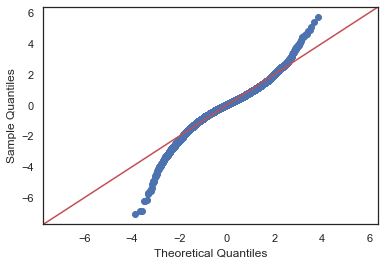

In [790]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

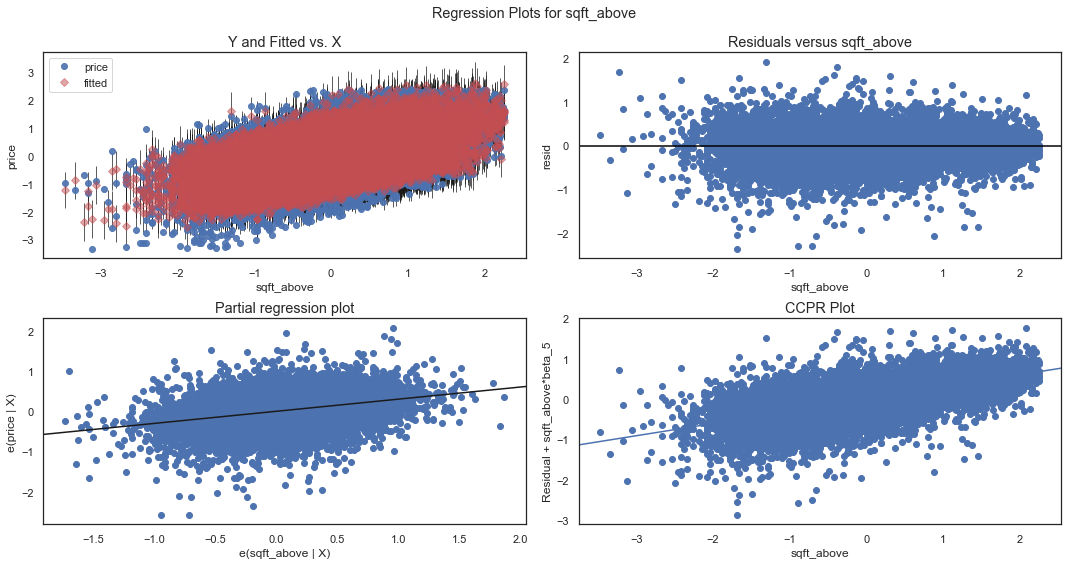

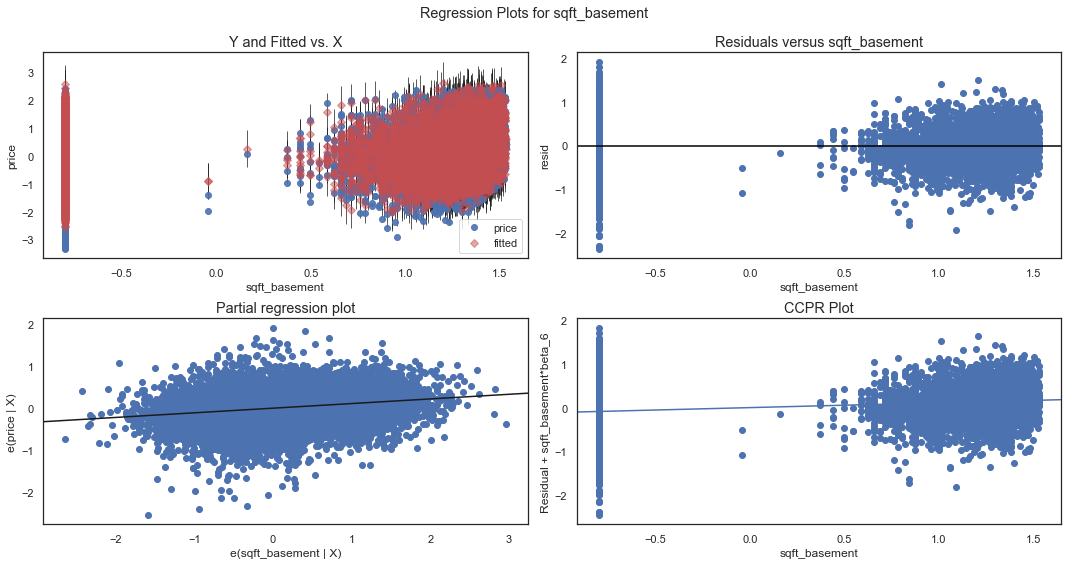

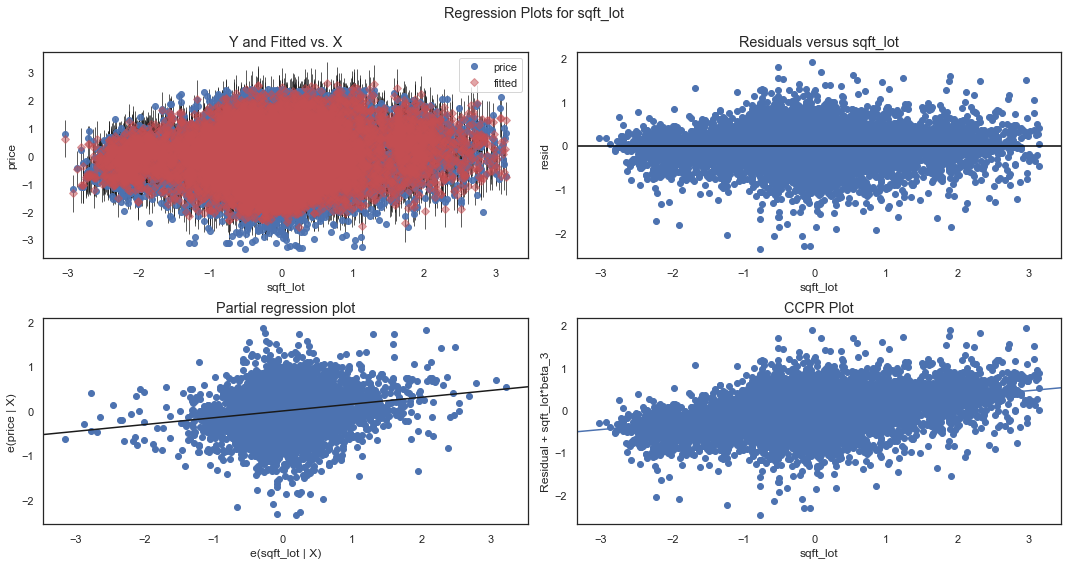

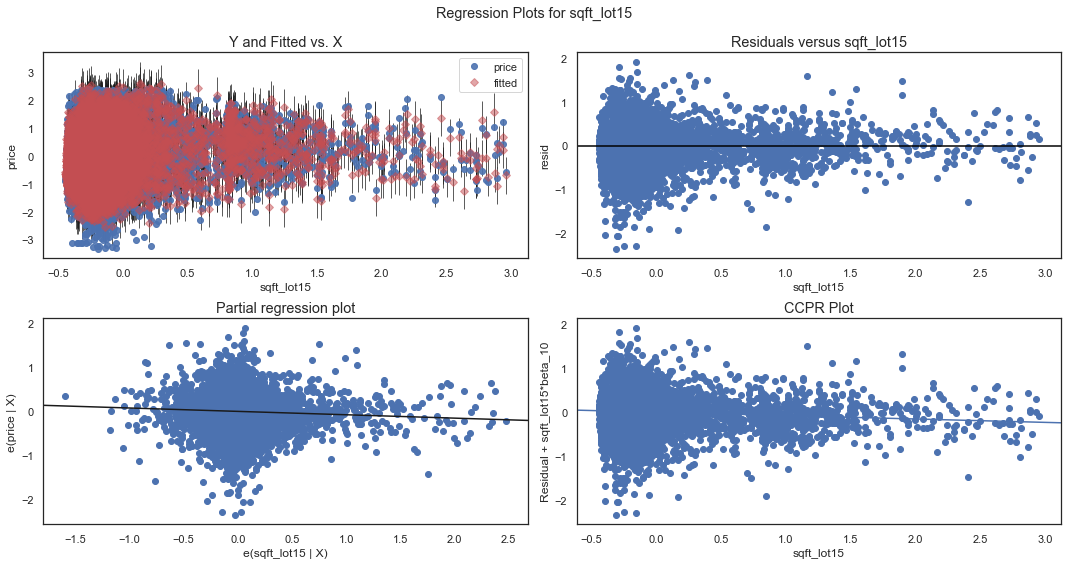

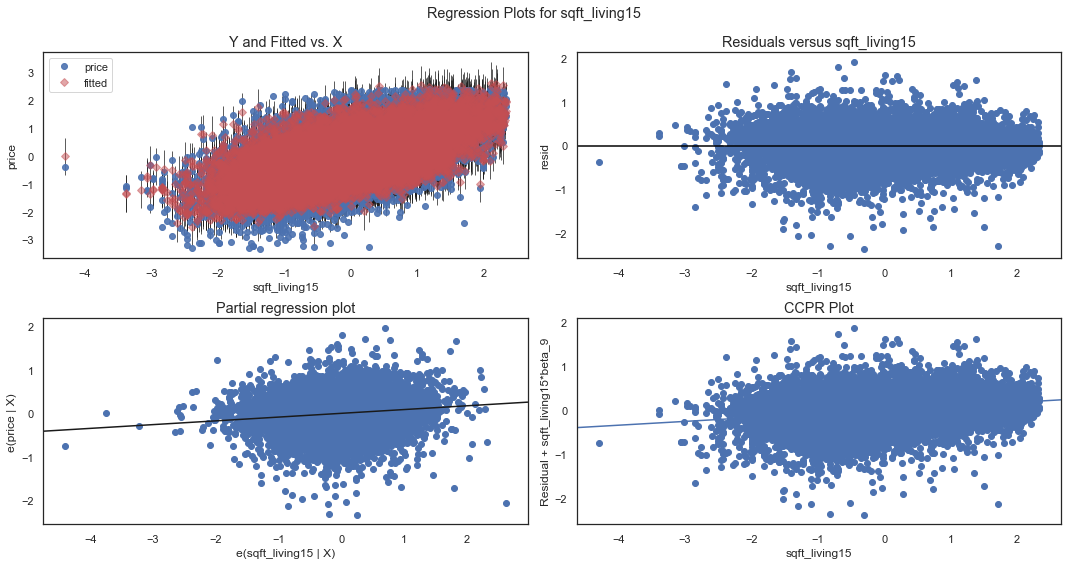

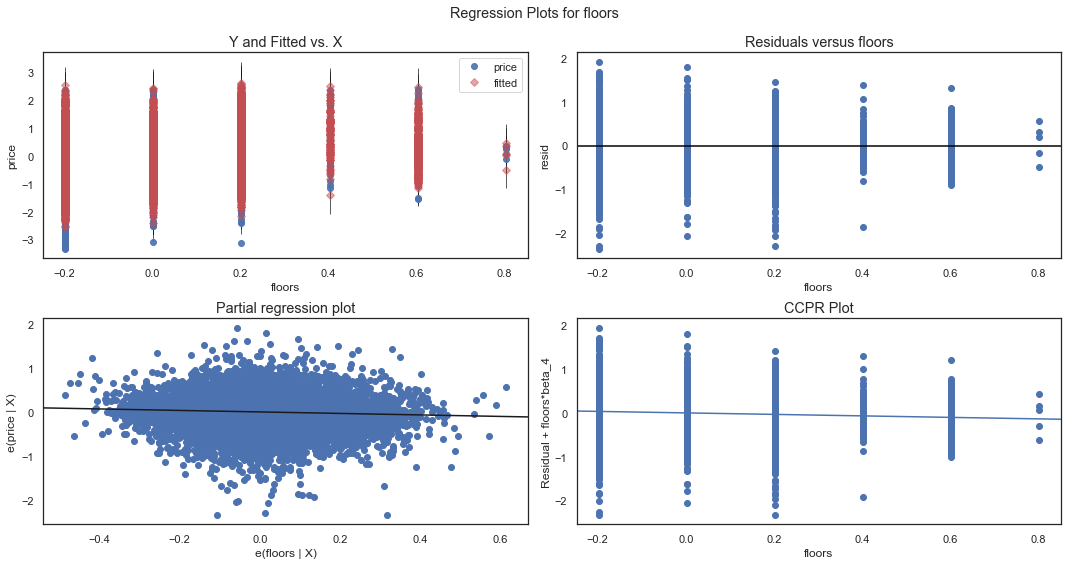

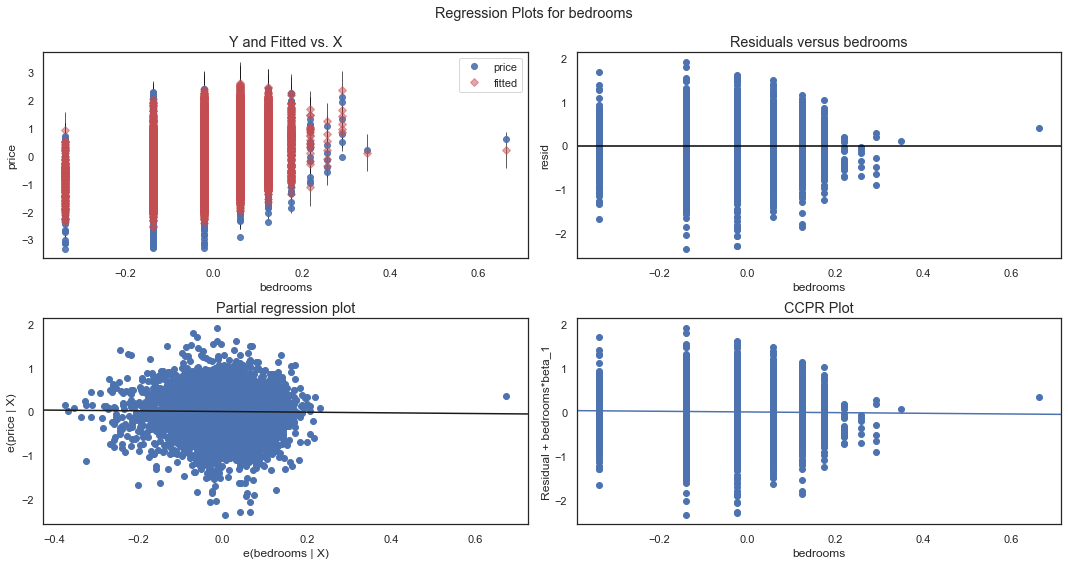

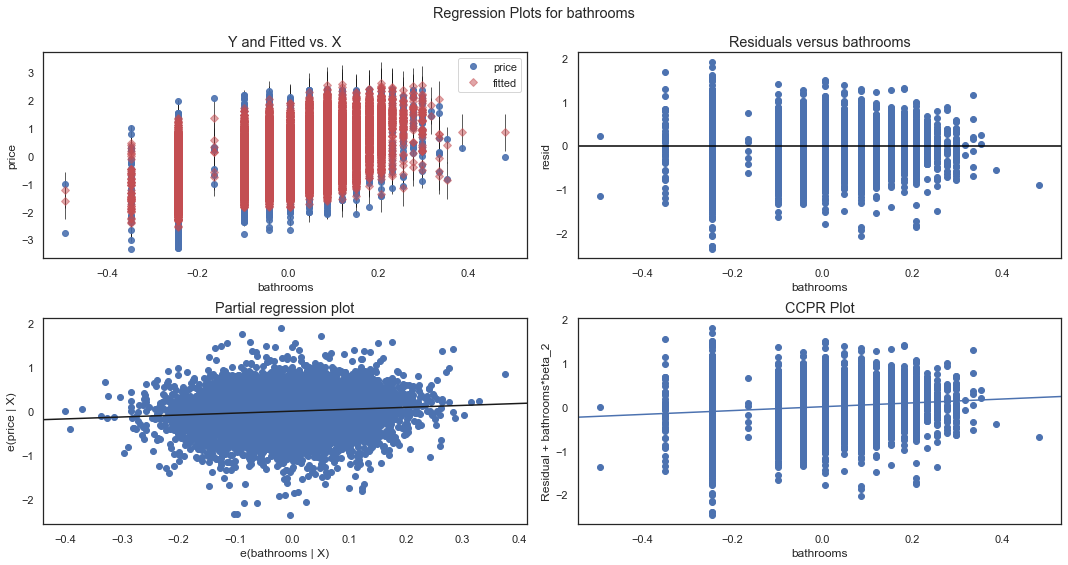

In [791]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_basement','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [792]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 6236.453498202881),
 ('Prob', 0.0),
 ('Skew', -0.40774931575058304),
 ('Kurtosis', 5.920015849535342)]

### Trial 3 Discussion:
Overall eliminating the outliers produced worse results. Thus for now, we will keep the outliers in the model and evaluate again when we achieve a final model. The next step is to see if we can reduce the number of predictors in the model. The first method of choice is eliminating or changing the way zipcode is categorized.

## Trial 4:  Zipcode Investigation

* Categorial predictors: view, waterfront, grade, condition (binned), yr_built (binned), renovated,zipcode
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_basement, sqft_living15, sqft_living
* Notes: log transformed sqft_above, sqft_living15, sqft_lot, price, and sqft_basement. 


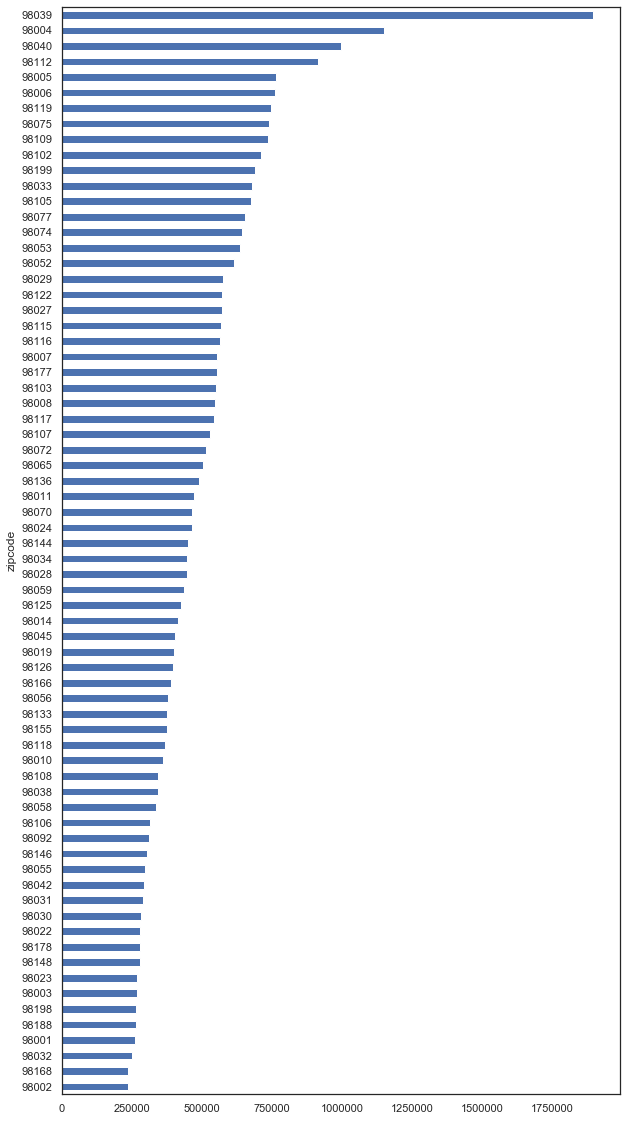

In [793]:
df2.groupby('zipcode')['price'].median().sort_values().plot(kind='barh',figsize=(10,20))
plt.show()

Based off the bar graph there seems to be 4 zipcodes that differentiate themselves in terms of highest price. Further investigation is needed. 

In [794]:
df_zip=df.copy()
df_zip['prime_zipcode'] = df['zipcode'].isin([98039, 98004, 98040, 98112])

Thus a new column is made in the data of whether the zipcode of each entry is or is not a prime zipcode. The seperate categorial variables are eliminated after. 

In [795]:
prime_zip=pd.get_dummies(df_cat['prime_zipcode'],prefix='prime_zipcode')

In [796]:
testing4=new_df.copy()
testing4.drop(zipcode,axis=1,inplace=True)
testing4=pd.concat([testing4, prime_zip],axis=1)
testing4.head() 



id       date     price  bedrooms  bathrooms  sqft_lot    floors  \
0  7129300520 2014-10-13 -1.401998 -0.022653  -0.244401 -0.388430 -0.197639   
1  6414100192 2014-12-09  0.279938 -0.022653   0.048081 -0.113241  0.202361   
2  5631500400 2015-02-25 -1.799430 -0.138616  -0.244401  0.244475 -0.197639   
3  2487200875 2014-12-09  0.499698  0.059624   0.151840 -0.523914 -0.197639   
4  1954400510 2015-02-18  0.178434 -0.022653   0.005599  0.008139 -0.197639   

   sqft_above  sqft_basement      lat  ...  yr_built_(1972, 1982]  \
0   -0.753565      -0.798211  47.5112  ...                      0   
1    0.672693       1.092003  47.7210  ...                      0   
2   -1.752954      -0.798211  47.7379  ...                      0   
3   -1.026835       1.350776  47.5208  ...                      0   
4    0.073515      -0.798211  47.6168  ...                      0   

   yr_built_(1982, 1990]  yr_built_(1990, 2000]  yr_built_(2000, 2007]  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      1                      0                      0   

   yr_built_(2007, 2009]  yr_built_(2009, 2020]  Renovated?_False  \
0                      0                      0                 1   
1                      0                      0                 0   
2                      0                      0                 1   
3                      0                      0                 1   
4                      0                      0                 1   

   Renovated?_True  prime_zipcode_False  prime_zipcode_True  
0                0                    1                   0  
1                1                    1                   0  
2                0                    1                   0  
3                0                    1                   0  
4                0                    1                   0  

[5 rows x 46 columns]

In [797]:
x=testing4.drop(['id','date','price'],axis=1)
y=testing4.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [798]:
testing4.head()

id       date     price  bedrooms  bathrooms  sqft_lot    floors  \
0  7129300520 2014-10-13 -1.401998 -0.022653  -0.244401 -0.388430 -0.197639   
1  6414100192 2014-12-09  0.279938 -0.022653   0.048081 -0.113241  0.202361   
2  5631500400 2015-02-25 -1.799430 -0.138616  -0.244401  0.244475 -0.197639   
3  2487200875 2014-12-09  0.499698  0.059624   0.151840 -0.523914 -0.197639   
4  1954400510 2015-02-18  0.178434 -0.022653   0.005599  0.008139 -0.197639   

   sqft_above  sqft_basement      lat  ...  yr_built_(1972, 1982]  \
0   -0.753565      -0.798211  47.5112  ...                      0   
1    0.672693       1.092003  47.7210  ...                      0   
2   -1.752954      -0.798211  47.7379  ...                      0   
3   -1.026835       1.350776  47.5208  ...                      0   
4    0.073515      -0.798211  47.6168  ...                      0   

   yr_built_(1982, 1990]  yr_built_(1990, 2000]  yr_built_(2000, 2007]  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      1                      0                      0   

   yr_built_(2007, 2009]  yr_built_(2009, 2020]  Renovated?_False  \
0                      0                      0                 1   
1                      0                      0                 0   
2                      0                      0                 1   
3                      0                      0                 1   
4                      0                      0                 1   

   Renovated?_True  prime_zipcode_False  prime_zipcode_True  
0                0                    1                   0  
1                1                    1                   0  
2                0                    1                   0  
3                0                    1                   0  
4                0                    1                   0  

[5 rows x 46 columns]

In [799]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1911.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:05:54   Log-Likelihood:                -10656.
No. Observations:               17277   AIC:                         2.139e+04
Df Residuals:                   17240   BIC:                         2.167e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -36.3586      1.172    -31.023      0.000     -38.656     -34.061
bedrooms                 -0.3591      0.058     -6.171      0.000      -0.473      -0.245
bathrooms                 0.5641      0.044     12.694      0.000       0.477       0.651
sqft_lot                  0.0059      0.006      0.941      0.347      -0.006       0.018
floors                    0.0142      0.027      0.531      0.596      -0.038       0.067
sqft_above                0.2716      0.008     32.160      0.000       0.255       0.288
sqft_basement             0.1416      0.005     29.415      0.000       0.132       0.151
lat                       2.5690      0.026     97.104      0.000       2.517       2.621
long                     -0.0224      0.031     -0.722      0.471      -0.083       0.038
sqft_living15             0.0983      0.006     17.004      0.000       0.087       0.110
sqft_lot15                0.0300      0.005      6.331      0.000       0.021       0.039
condition_(0, 2]        -18.3527      0.587    -31.286      0.000     -19.502     -17.203
condition_(2, 5]        -18.0059      0.586    -30.730      0.000     -19.154     -16.857
view_0.0                 -7.5960      0.234    -32.479      0.000      -8.054      -7.138
view_1.0                 -7.2829      0.236    -30.815      0.000      -7.746      -6.820
view_2.0                 -7.3312      0.235    -31.238      0.000      -7.791      -6.871
view_3.0                 -7.1981      0.235    -30.578      0.000      -7.660      -6.737
view_4.0                 -6.9503      0.236    -29.411      0.000      -7.414      -6.487
waterfront_0.0          -18.5285      0.586    -31.623      0.000     -19.677     -17.380
waterfront_1.0          -17.8301      0.587    -30.366      0.000     -18.981     -16.679
grade_3                  -3.1328      0.421     -7.444      0.000      -3.958      -2.308
grade_4                  -4.4970      0.145    -31.033      0.000      -4.781      -4.213
grade_5                  -4.2820      0.117    -36.723      0.000      -4.511      -4.053
grade_6                  -4.0405      0.115    -35.142      0.000      -4.266      -3.815
grade_7                  -3.7969      0.115    -32.978      0.000      -4.023      -3.571
grade_8                  -3.5341      0.116    -30.488      0.000      -3.761      -3.307
grade_9                  -3.2197      0.117    -27.527      0.000      -3.449      -2.990
grade_10                 -2.9546      0.118    -24.971      0.000      -3.186      -2.723
grade_11                 -2.7134      0.121    -22.450      0.000      -2.950      -2.476
grade_12                 -2.3137      0.129    -17.953      0.000      -2.566      -2.061
grade_13                 -1.8739      0.178    -10.537      0.000      -2.222      -1.525
yr_built_(1899, 1928]  

In [800]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.201013908403363
Test Mean Squarred Error: 0.20902116657399727


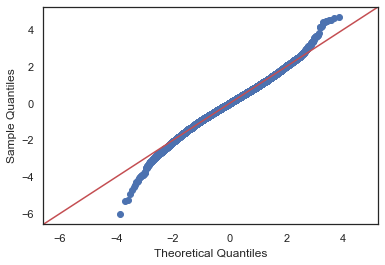

In [801]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

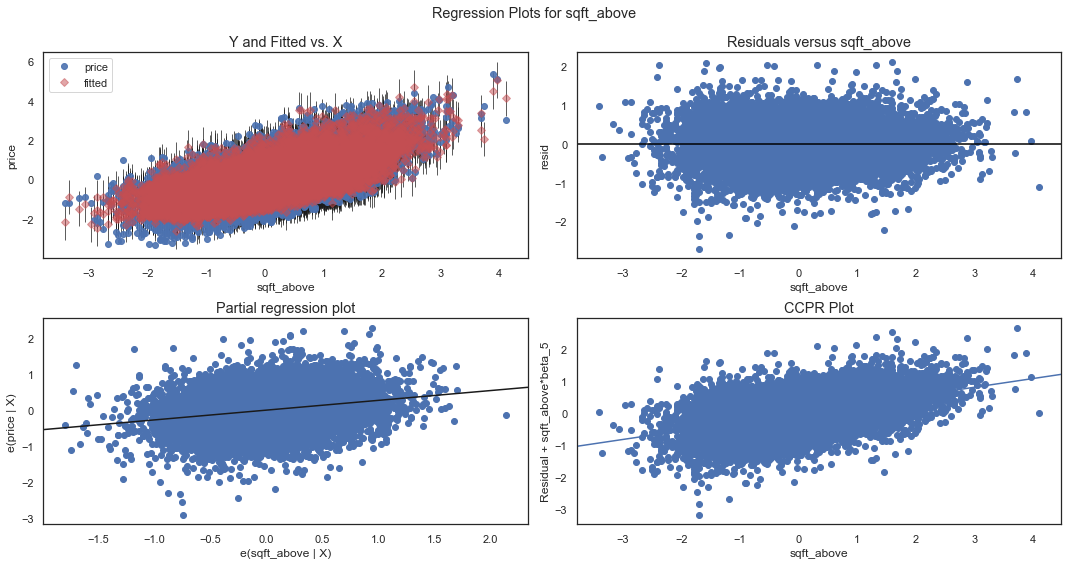

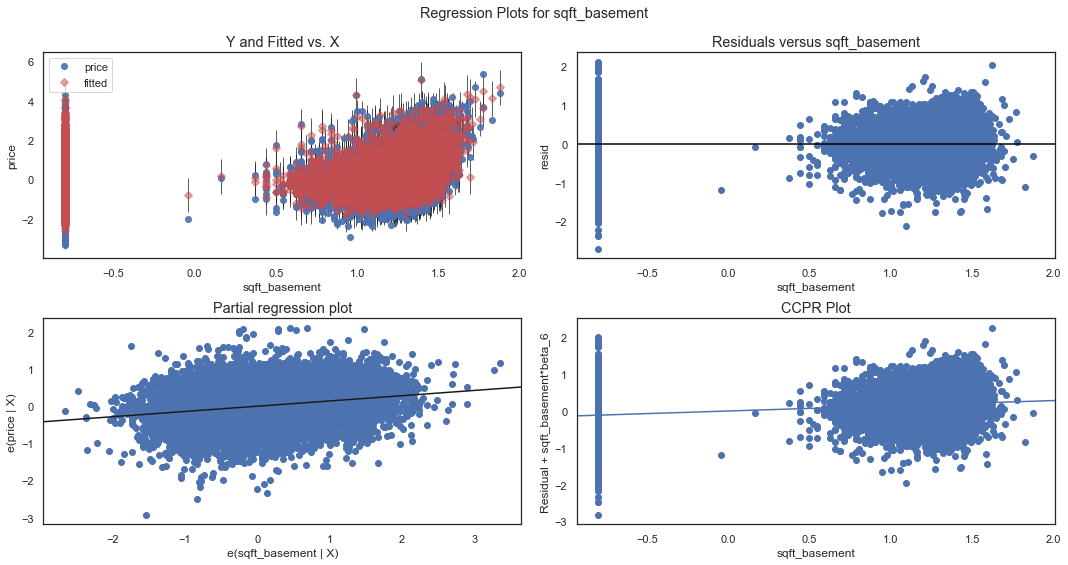

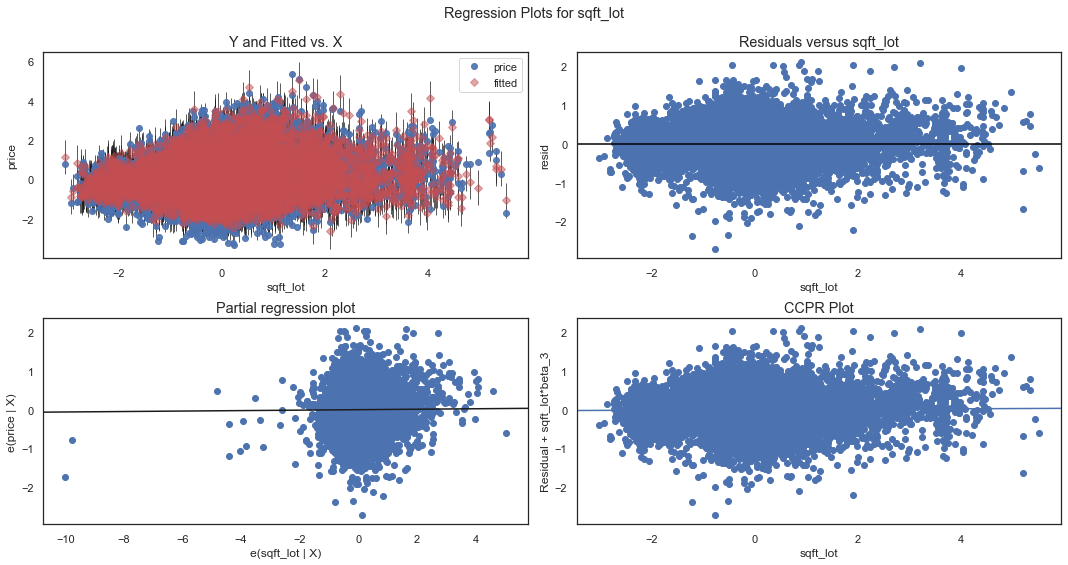

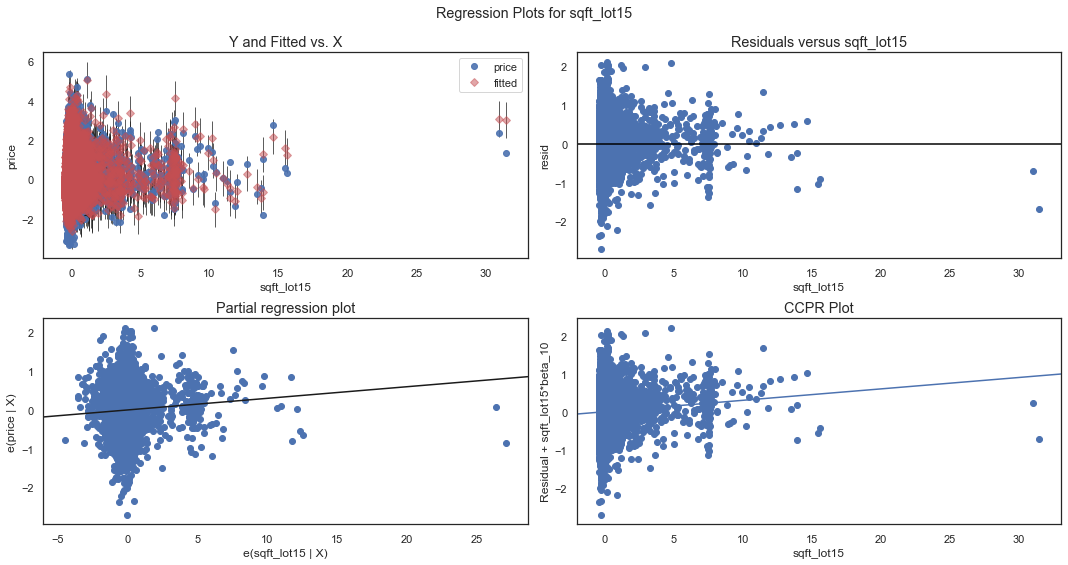

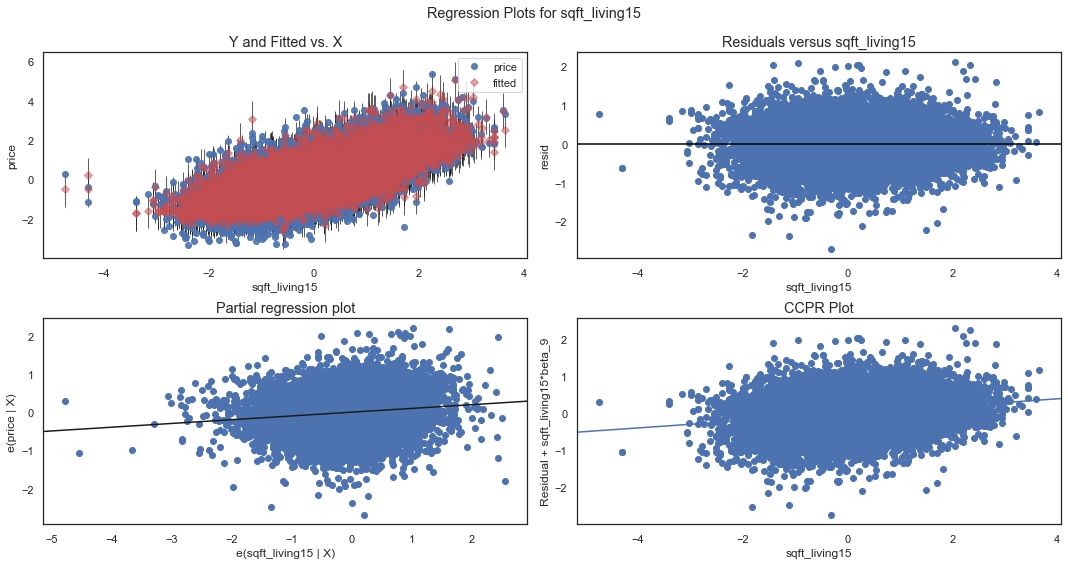

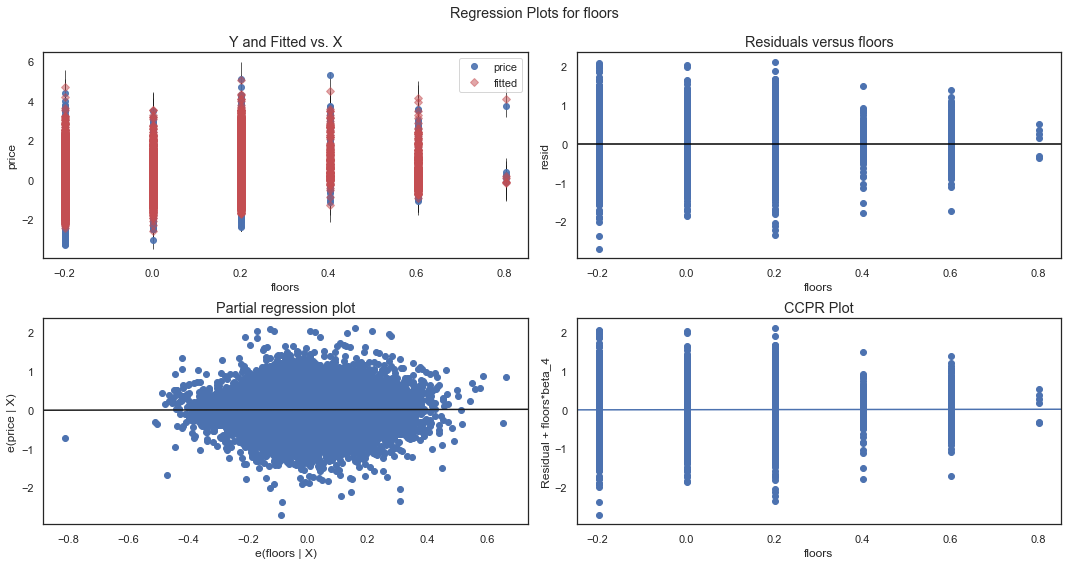

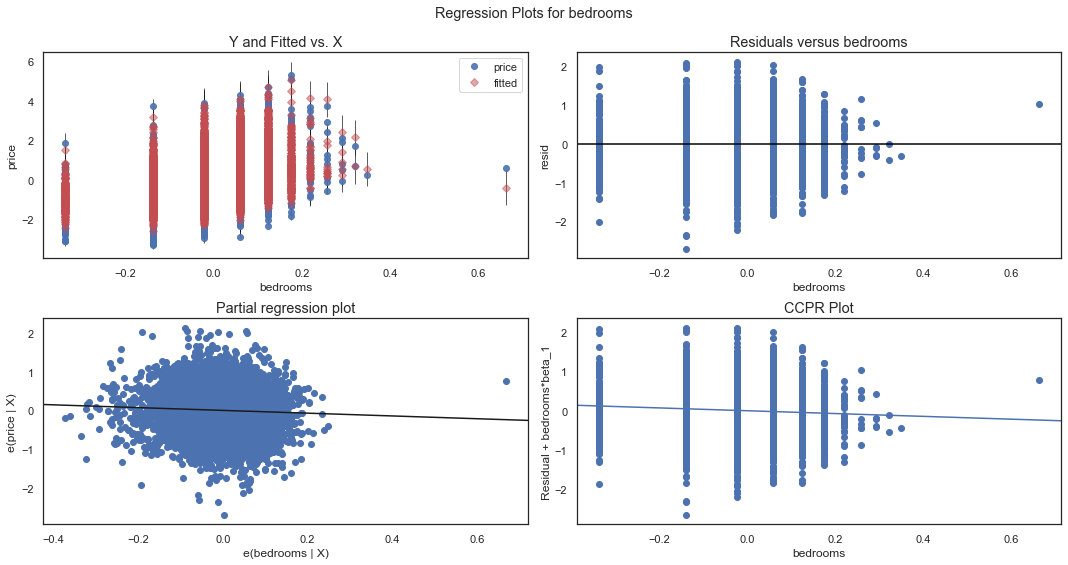

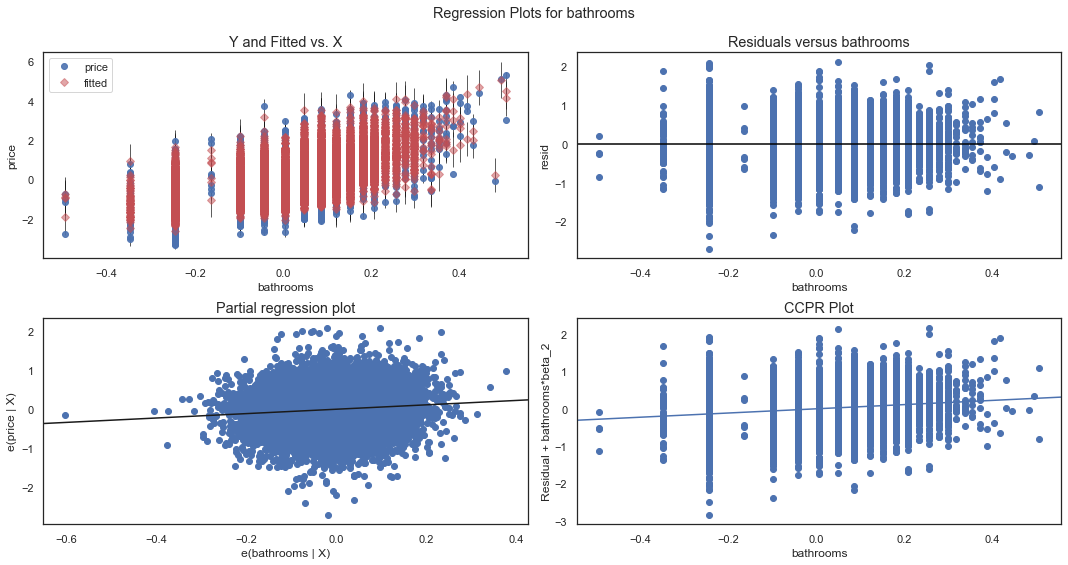

In [802]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_basement','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [803]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 666.3868257994981),
 ('Prob', 1.976693668208822e-145),
 ('Skew', -0.09150272695005032),
 ('Kurtosis', 3.9445670825043164)]

### Trial 4 Discussion:
This produced significantly better results as the normality of the residuals is more in line of a normal distribution as seen by the Q-Q plot and Jarque-Bera value. In addition, the skewness and kurtosis is more in line with normal distribution. Thus, this prime_zipcode predictor will be kept. The next point of focus is to reduce further reduce the number of predictors by binning grade. 

## Trial 5: Binning Grade

* Categorial predictors: view, waterfront, grade (binned), condition (binned), yr_built (binned), renovated,zipcode 
* Quantitative predictors: bedrooms, bathrooms, floors, sqft_lot, sqft_above, lat, long, sqft_basement, sqft_living15, sqft_living
* Notes: Only change is that grade has been binned then categorized. 


Let's first look at the histogram for grade.

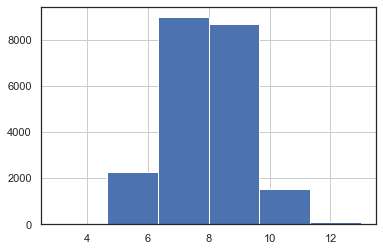

In [804]:
df2.grade.hist(bins=6)
plt.show()

It seems that 3 bins for grades of 0-7, 7-9, and 9-13 is the logical choice. After further research it is found that grade represents the construction quality of improvements and they are generally defined as:

* 1-3: Falls short of minimum building standards. Normally cabin or inferior structure.

* 4: Generally older, low quality construction. Does not meet code.

* 5: Low construction costs and workmanship. Small, simple design.

* 6: Lowest grade currently meeting building code. Low quality materials and simple designs.

* 7: Average grade of construction and design. Commonly seen in plats and older sub-divisions.

* 8: Just above average in construction and design. Usually better materials in both the exterior and interior finish work.

* 9: Better architectural design with extra interior and exterior design and quality.

* 10: Homes of this quality generally have high quality features. Finish work is better and more design quality is seen in the floor plans. Generally have a larger square footage.

* 11: Custom design and higher quality finish work with added amenities of solid woods, bathroom fixtures and more luxurious options.

* 12: Custom design and excellent builders. All materials are of the highest quality and all conveniences are present.

* 13: Generally custom designed and built. Mansion level. Large amount of highest quality cabinet work, wood trim, marble, entry ways etc.

Taking into account these descriptions along with the distribution of the predictor, 3 bins are created that consist of a grade of below average, average, and above average with grades of 1-6 being below average, grades 7-9 being average, and grades 10-13 being above average.

In [805]:
grade_bins=[0,6,9,13]
grade_bins=pd.cut(df2['grade'], grade_bins)
grade_bins = grade_bins.cat.as_unordered()
new_grade=pd.get_dummies(grade_bins,prefix='grade')


testing5=testing4.copy()
testing5.drop(grade,axis=1,inplace=True)
testing5=pd.concat([testing5, new_grade],axis=1)
testing5.head() 

id       date     price  bedrooms  bathrooms  sqft_lot    floors  \
0  7129300520 2014-10-13 -1.401998 -0.022653  -0.244401 -0.388430 -0.197639   
1  6414100192 2014-12-09  0.279938 -0.022653   0.048081 -0.113241  0.202361   
2  5631500400 2015-02-25 -1.799430 -0.138616  -0.244401  0.244475 -0.197639   
3  2487200875 2014-12-09  0.499698  0.059624   0.151840 -0.523914 -0.197639   
4  1954400510 2015-02-18  0.178434 -0.022653   0.005599  0.008139 -0.197639   

   sqft_above  sqft_basement      lat  ...  yr_built_(2000, 2007]  \
0   -0.753565      -0.798211  47.5112  ...                      0   
1    0.672693       1.092003  47.7210  ...                      0   
2   -1.752954      -0.798211  47.7379  ...                      0   
3   -1.026835       1.350776  47.5208  ...                      0   
4    0.073515      -0.798211  47.6168  ...                      0   

   yr_built_(2007, 2009]  yr_built_(2009, 2020]  Renovated?_False  \
0                      0                      0                 1   
1                      0                      0                 0   
2                      0                      0                 1   
3                      0                      0                 1   
4                      0                      0                 1   

   Renovated?_True  prime_zipcode_False  prime_zipcode_True  grade_(0, 6]  \
0                0                    1                   0             0   
1                1                    1                   0             0   
2                0                    1                   0             1   
3                0                    1                   0             0   
4                0                    1                   0             0   

   grade_(6, 9]  grade_(9, 13]  
0             1              0  
1             1              0  
2             0              0  
3             1              0  
4             1              0  

[5 rows x 38 columns]

In [806]:
x=testing5.drop(['id','date','price','sqft_lot','floors','waterfront_0.0','Renovated?_False','prime_zipcode_False','sqft_basement'],axis=1)
y=testing5.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [807]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                     2242.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        21:06:18   Log-Likelihood:                -12045.
No. Observations:               17277   AIC:                         2.414e+04
Df Residuals:                   17251   BIC:                         2.434e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -78.0869      1.868    -41.798      0.000     -81.749     -74.425
bedrooms                 -0.1370      0.061     -2.259      0.024      -0.256      -0.018
bathrooms                 1.2392      0.043     28.489      0.000       1.154       1.324
sqft_above                0.2452      0.007     35.843      0.000       0.232       0.259
lat                       2.7776      0.028     99.638      0.000       2.723       2.832
long                     -0.2911      0.032     -9.155      0.000      -0.353      -0.229
sqft_living15             0.1944      0.006     33.540      0.000       0.183       0.206
sqft_lot15                0.0408      0.004     10.166      0.000       0.033       0.049
condition_(0, 2]        -39.2409      0.934    -42.003      0.000     -41.072     -37.410
condition_(2, 5]        -38.8460      0.934    -41.576      0.000     -40.677     -37.015
view_0.0                -16.0400      0.372    -43.081      0.000     -16.770     -15.310
view_1.0                -15.6461      0.375    -41.701      0.000     -16.382     -14.911
view_2.0                -15.6710      0.374    -41.931      0.000     -16.404     -14.938
view_3.0                -15.5114      0.375    -41.412      0.000     -16.246     -14.777
view_4.0                -15.2185      0.376    -40.501      0.000     -15.955     -14.482
waterfront_1.0            0.6522      0.055     11.897      0.000       0.545       0.760
yr_built_(1899, 1928]    -8.2726      0.211    -39.200      0.000      -8.686      -7.859
yr_built_(1928, 1933]    -8.3993      0.212    -39.653      0.000      -8.814      -7.984
yr_built_(1933, 1972]    -8.6936      0.209    -41.593      0.000      -9.103      -8.284
yr_built_(1972, 1982]    -8.8013      0.207    -42.559      0.000      -9.207      -8.396
yr_built_(1982, 1990]    -8.8621      0.206    -42.957      0.000      -9.266      -8.458
yr_built_(1990, 2000]    -8.8435      0.206    -42.941      0.000      -9.247      -8.440
yr_built_(2000, 2007]    -8.8104      0.206    -42.682      0.000      -9.215      -8.406
yr_built_(2007, 2009]    -8.7424      0.209    -41.881      0.000      -9.152      -8.333
yr_built_(2009, 2020]    -8.6617      0.207    -41.801      0.000      -9.068      -8.256
Renovated?_True           0.1058      0.021      5.046      0.000       0.065       0.147
prime_zipcode_True        0.9619      0.019     49.962      0.000       0.924       1.000
grade_(0, 6]            -26.3891      0.621    -42.480      0.000     -27.607     -25.171
grade_(6, 9]            -26.1126      0.623    -41.927      0.000     -27.333     -24.892
grade_(9, 13]           -25.5853      0.624    -40.974      0.000     -26.809     -24.361
==============================================================================
Omnibus:                      218.

In [808]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.23607763275368093
Test Mean Squarred Error: 0.24474135683294368


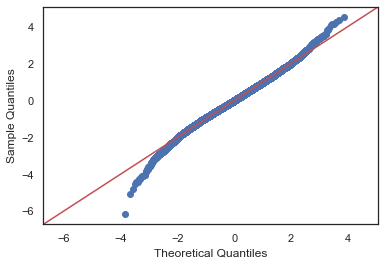

In [809]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

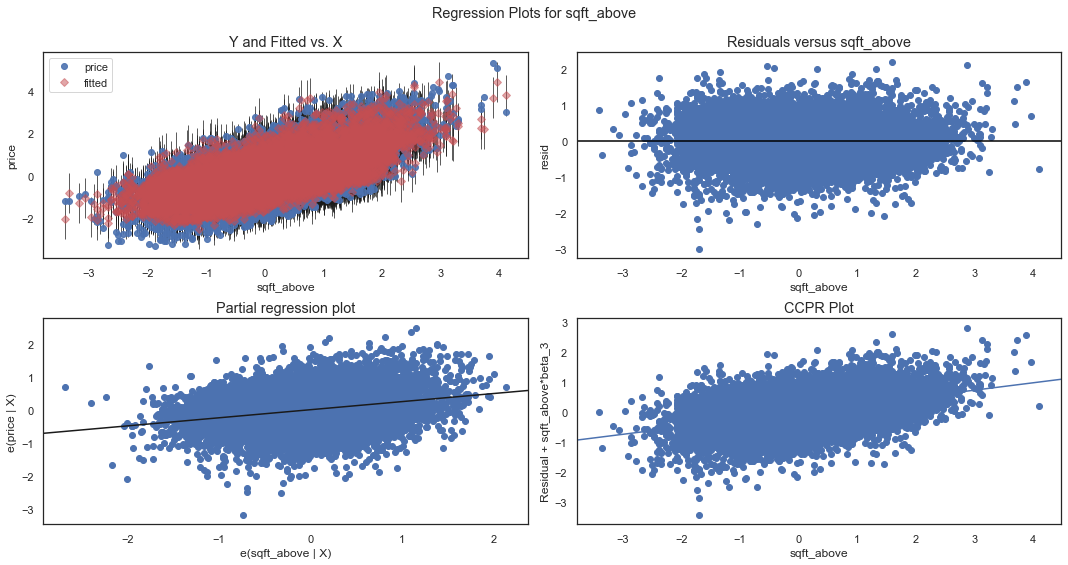

ValueError: 'sqft_basement' is not in list

<Figure size 1080x576 with 0 Axes>

In [810]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_basement','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [ ]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

Due to the improvement in the model from the manipulation of the zipcode data by binning. It is suspected that one single variable to represent the relationship between zipcode and price is possible and that would introducing a new variable "dist_from_top" which would be the distance from the average coordinates of the top 4 zipcodes. This variable has the potential to eliminate the zipcode categorical data as well as the longitude and latitude and incorporate these 3 data points into one single data. Let's see if this idea will actually improve the model. We'll first evaluate where these top 4 zipcodes are and if they are near each other.

AttributeError: 'numpy.ndarray' object has no attribute 'median'

In [811]:
df_zip=df.copy()
df_zip['prime_zipcode'] = df['zipcode'].isin([98039, 98004, 98040, 98112])

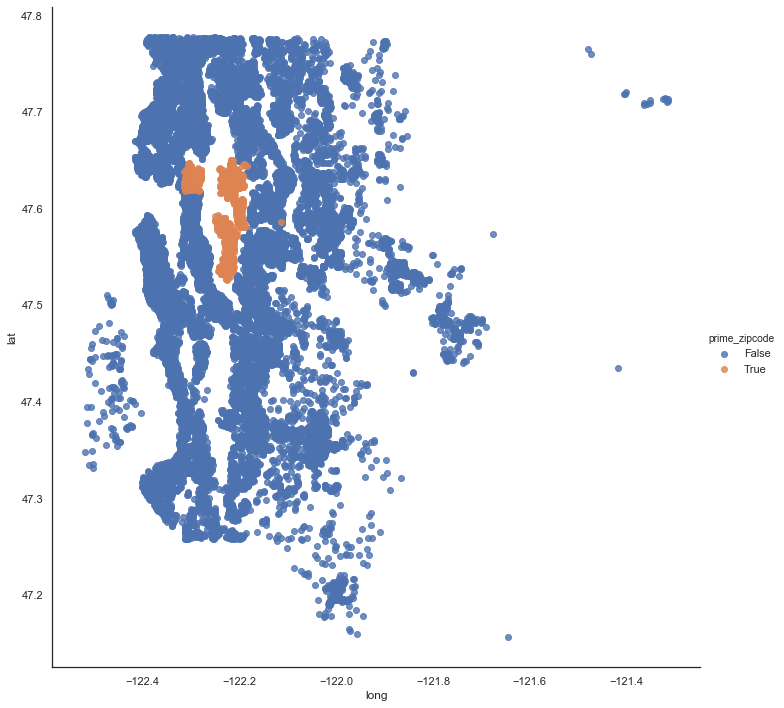

In [684]:
g = sns.lmplot(data=df_zip,x='long',y='lat',hue='prime_zipcode',height=10,fit_reg=False)

It looks like these top 4 zipcodes are near. Thus taking an average of them would be acceptable. It would not be acceptable if for example the top 4 zipcodes in price were all far from each other. This would cause the average coordinates of the top zipcodes to potentially be at a coordinate that is lower in price. Let's find out what the average coordinates are. 

In [685]:
prime=df_zip['zipcode'].isin([98039, 98004, 98040, 98112])
coordinates=[df_zip[prime].lat.mean(),df_zip[prime].long.mean()]
print(coordinates)

[47.60333997821352, -122.2401579520698]


These average coordinates further validate that the introduction of this variable "dist_from_top" has the potential to be useful in that the coordinates of Downtown Seattle are ( 47.6050, -122.3344 ) and Belluve 47.6101, -122.2015 . These coordinates are very close to the average coordinates of the top 4 zipcodes. Therefore, the next step is to populate this variable and incorporate it into the model. 

In [686]:
import math

coordinates=[47.608013,-122.335167]
radius=3958.8

def dist_calc(lat2,lon2):
    lat1=math.radians(coordinates[0])
    lon1=math.radians(coordinates[1])
    lat2=math.radians(lat2)
    lon2=math.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    dist = radius * c
    return dist

In [687]:
testing6=testing5.copy()
testing6['dist_from_top'] = df.apply(lambda x: dist_calc(x['lat'], x['long']), axis=1)


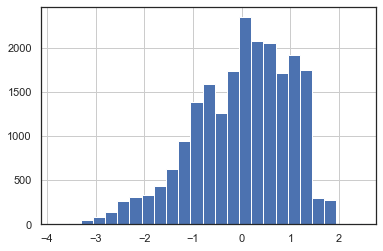

In [688]:
testing6.dist_from_top=np.log(testing6.dist_from_top)
testing6.dist_from_top=(testing6.dist_from_top-testing6.dist_from_top.mean())/testing6.dist_from_top.std()
testing6.dist_from_top.hist(bins=25)

In [689]:
#testing6.drop(prime_zip,axis=1,inplace=True)
#testing6.drop(['long','lat'],axis=1,inplace=True)
testing6.head()

id       date     price  bedrooms  bathrooms  sqft_lot    floors  \
0  7129300520 2014-10-13 -1.401998 -0.022653  -0.244401 -0.388430 -0.197639   
1  6414100192 2014-12-09  0.279938 -0.022653   0.048081 -0.113241  0.202361   
2  5631500400 2015-02-25 -1.799430 -0.138616  -0.244401  0.244475 -0.197639   
3  2487200875 2014-12-09  0.499698  0.059624   0.151840 -0.523914 -0.197639   
4  1954400510 2015-02-18  0.178434 -0.022653   0.005599  0.008139 -0.197639   

   sqft_above  sqft_basement      lat  ...  yr_built_(2007, 2009]  \
0   -0.753565      -0.798211  47.5112  ...                      0   
1    0.672693       1.092003  47.7210  ...                      0   
2   -1.752954      -0.798211  47.7379  ...                      0   
3   -1.026835       1.350776  47.5208  ...                      0   
4    0.073515      -0.798211  47.6168  ...                      0   

   yr_built_(2009, 2020]  Renovated?_False  Renovated?_True  \
0                      0                 1                0   
1                      0                 0                1   
2                      0                 1                0   
3                      0                 1                0   
4                      0                 1                0   

   prime_zipcode_False  prime_zipcode_True  grade_(0, 6]  grade_(6, 9]  \
0                    1                   0             0             1   
1                    1                   0             0             1   
2                    1                   0             1             0   
3                    1                   0             0             1   
4                    1                   0             0             1   

   grade_(9, 13]  dist_from_top  
0              0      -0.337593  
1              0      -0.293581  
2              0       0.096727  
3              0      -0.553816  
4              0       0.529987  

[5 rows x 39 columns]

In [690]:
x=testing6.drop(['id','date','price'],axis=1)
y=testing6.price
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [691]:
x_train.columns

Index(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'condition_(0, 2]', 'condition_(2, 5]', 'view_0.0', 'view_1.0',
       'view_2.0', 'view_3.0', 'view_4.0', 'waterfront_0.0', 'waterfront_1.0',
       'yr_built_(1899, 1928]', 'yr_built_(1928, 1933]',
       'yr_built_(1933, 1972]', 'yr_built_(1972, 1982]',
       'yr_built_(1982, 1990]', 'yr_built_(1990, 2000]',
       'yr_built_(2000, 2007]', 'yr_built_(2007, 2009]',
       'yr_built_(2009, 2020]', 'Renovated?_False', 'Renovated?_True',
       'prime_zipcode_False', 'prime_zipcode_True', 'grade_(0, 6]',
       'grade_(6, 9]', 'grade_(9, 13]', 'dist_from_top'],
      dtype='object')

In [692]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     2647.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:29:50   Log-Likelihood:                -9894.1
No. Observations:               17277   AIC:                         1.985e+04
Df Residuals:                   17247   BIC:                         2.008e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.7284      1.274      2.927      0.003       1.231       6.226
bedrooms                 -0.4839      0.055     -8.769      0.000      -0.592      -0.376
bathrooms                 0.5807      0.042     13.721      0.000       0.498       0.664
sqft_lot                  0.0982      0.006     15.770      0.000       0.086       0.110
floors                   -0.1287      0.026     -5.012      0.000      -0.179      -0.078
sqft_above                0.3905      0.008     50.835      0.000       0.375       0.406
sqft_basement             0.1308      0.005     28.399      0.000       0.122       0.140
lat                       1.8630      0.029     64.536      0.000       1.806       1.920
long                      0.8290      0.034     24.518      0.000       0.763       0.895
sqft_living15             0.1505      0.005     28.058      0.000       0.140       0.161
sqft_lot15                0.0043      0.005      0.937      0.349      -0.005       0.013
condition_(0, 2]          1.6470      0.637      2.585      0.010       0.398       2.896
condition_(2, 5]          2.0814      0.637      3.266      0.001       0.832       3.331
view_0.0                  0.4121      0.255      1.618      0.106      -0.087       0.911
view_1.0                  0.7152      0.256      2.789      0.005       0.213       1.218
view_2.0                  0.6672      0.255      2.618      0.009       0.168       1.167
view_3.0                  0.8253      0.256      3.229      0.001       0.324       1.326
view_4.0                  1.1086      0.256      4.323      0.000       0.606       1.611
waterfront_0.0            1.4896      0.637      2.340      0.019       0.242       2.737
waterfront_1.0            2.2388      0.638      3.507      0.000       0.988       3.490
yr_built_(1899, 1928]     0.5395      0.142      3.798      0.000       0.261       0.818
yr_built_(1928, 1933]     0.5245      0.145      3.629      0.000       0.241       0.808
yr_built_(1933, 1972]     0.3561      0.144      2.481      0.013       0.075       0.637
yr_built_(1972, 1982]     0.3011      0.143      2.113      0.035       0.022       0.580
yr_built_(1982, 1990]     0.3299      0.142      2.322      0.020       0.051       0.608
yr_built_(1990, 2000]     0.3498      0.141      2.477      0.013       0.073       0.627
yr_built_(2000, 2007]     0.3764      0.141      2.673      0.008       0.100       0.652
yr_built_(2007, 2009]     0.4168      0.142      2.931      0.003       0.138       0.695
yr_built_(2009, 2020]     0.5343      0.141      3.778      0.000       0.257       0.812
Renovated?_False          1.8069      0.637      2.835      0.005       0.558       3.056
Renovated?_True           1.9216      0.637      3.017      0.003       0.673       3.170
prime_zipcode_False    

In [578]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.18405380234122917
Test Mean Squarred Error: 0.19128719395541136


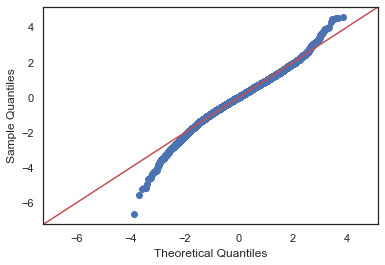

In [579]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

<Figure size 1080x576 with 0 Axes>

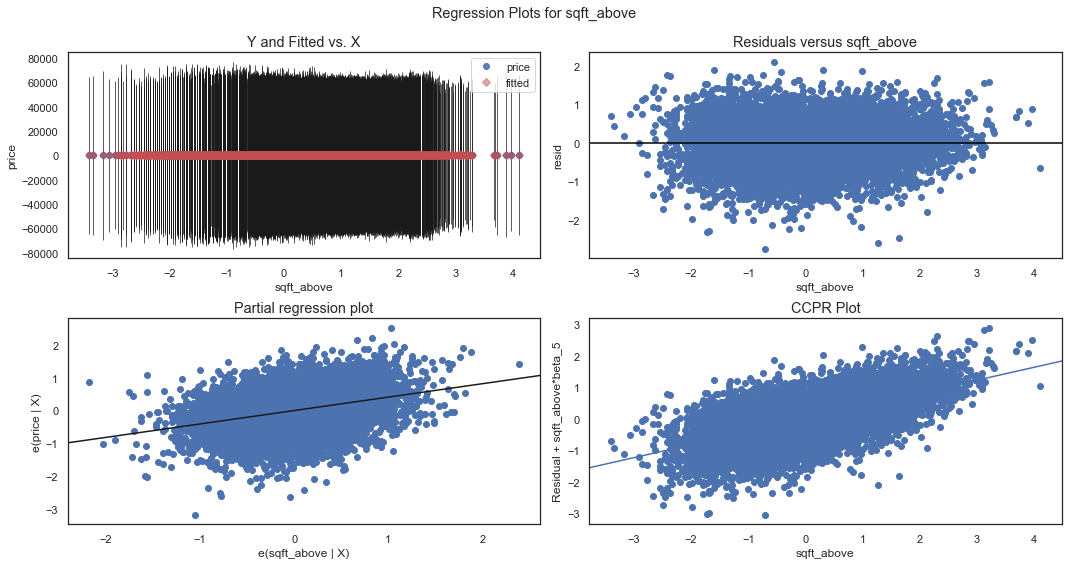

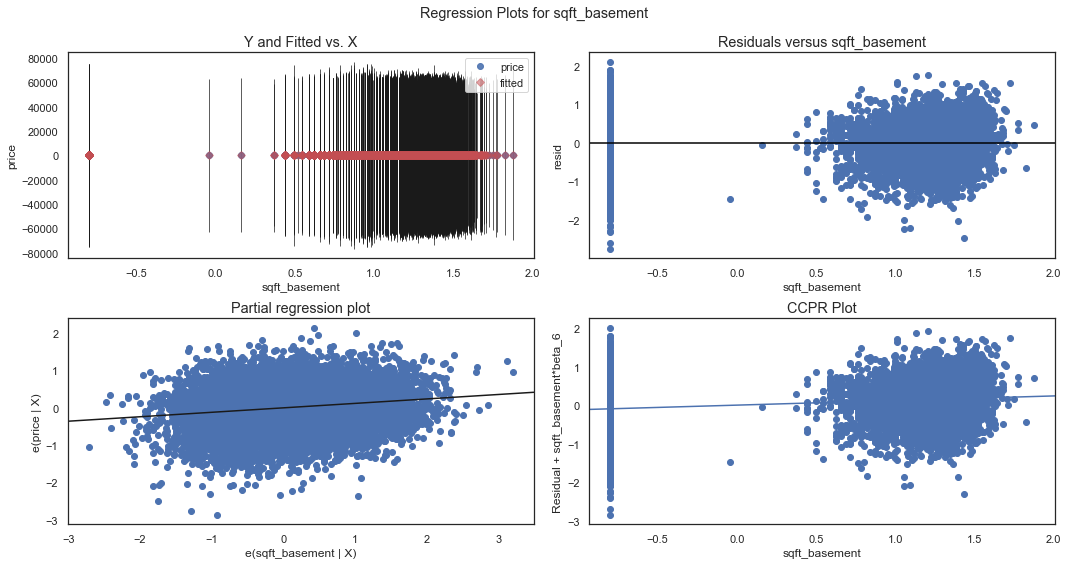

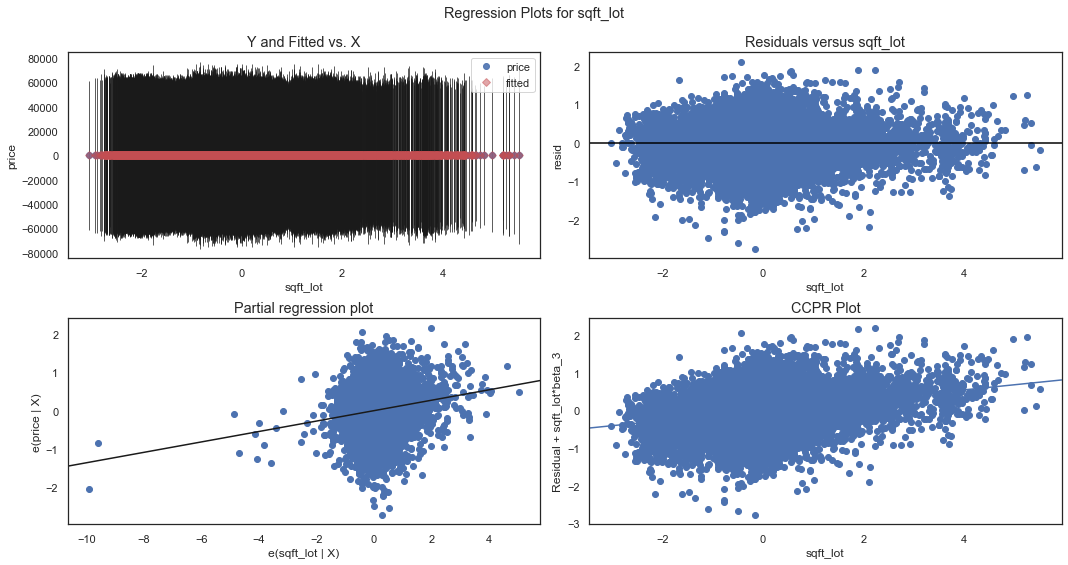

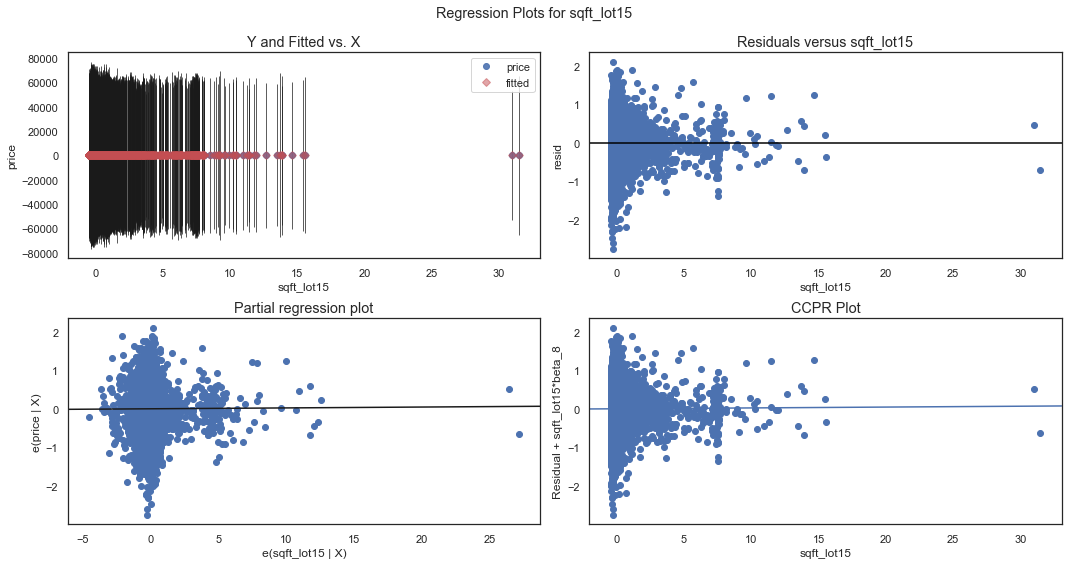

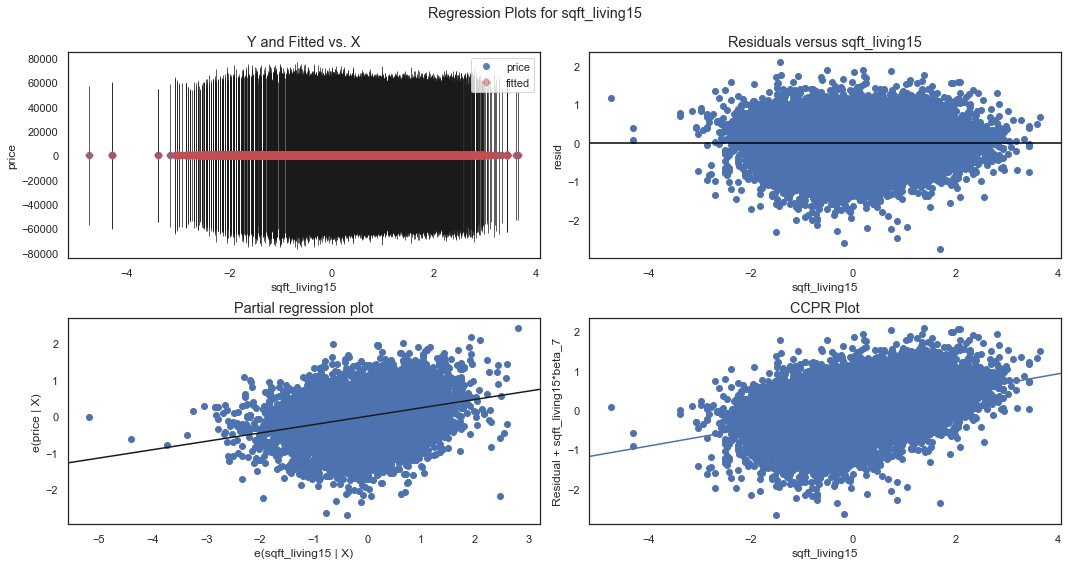

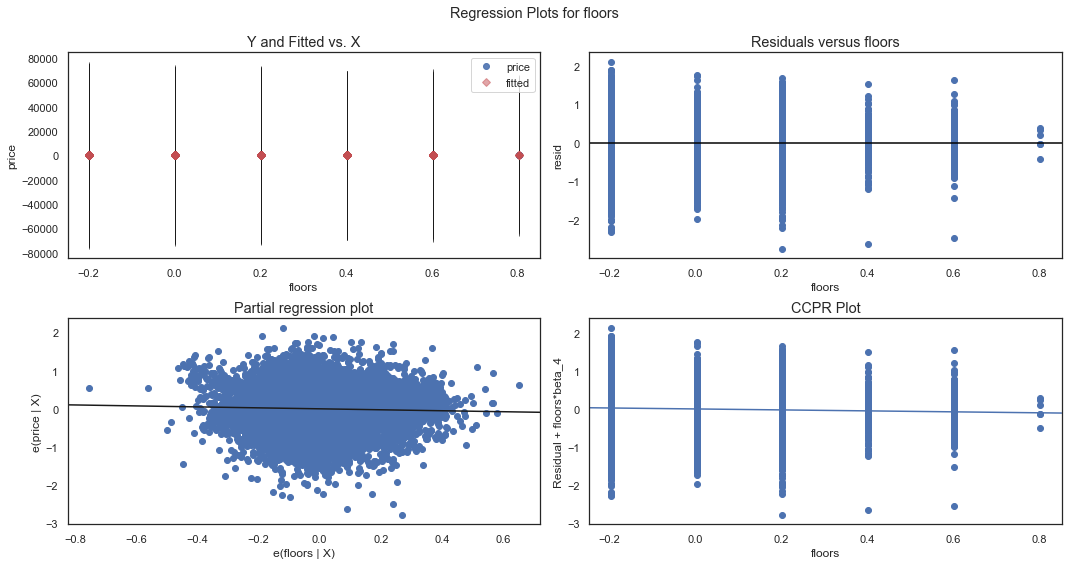

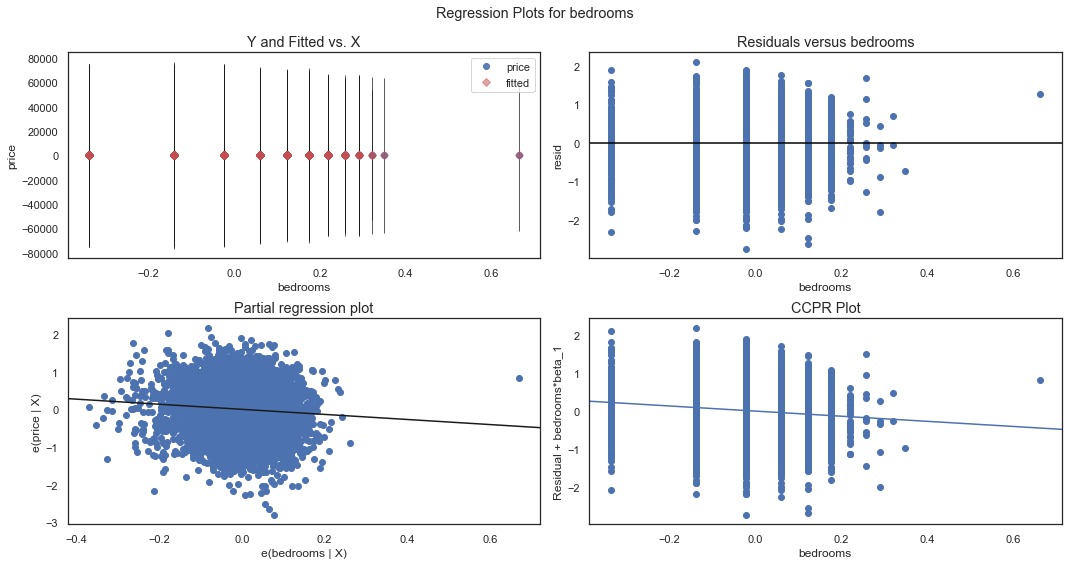

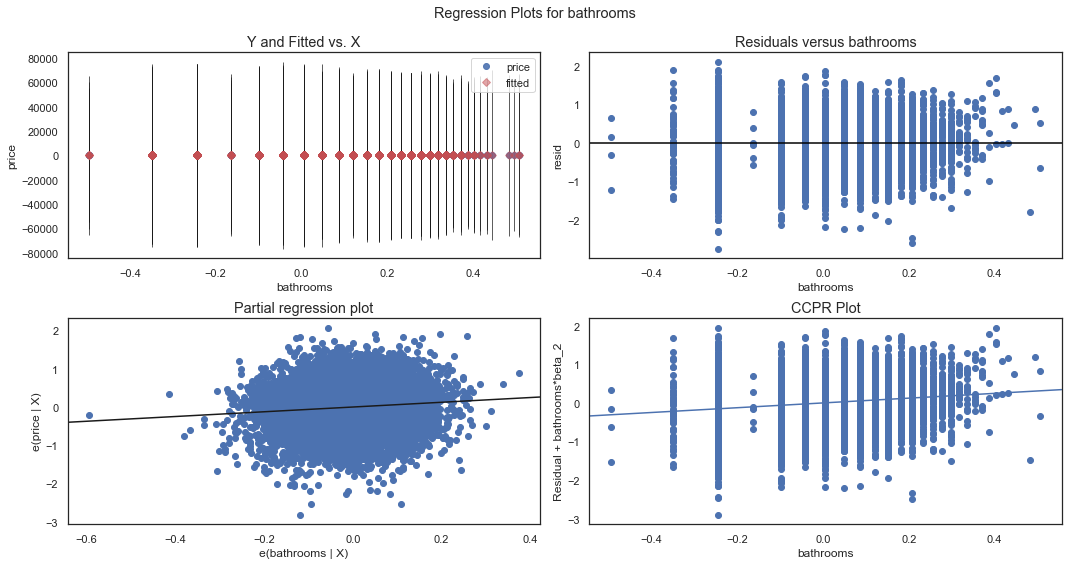

In [477]:
fig = plt.figure(figsize=(15,8))
for col in ['sqft_above','sqft_basement','sqft_lot','sqft_lot15','sqft_living15','floors','bedrooms','bathrooms']:
    fig = plt.figure(figsize=(15,8))
    fig = sm.graphics.plot_regress_exog(model, col, fig=fig)
    plt.show()

In [478]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 323.243384218176),
 ('Prob', 6.435628424141926e-71),
 ('Skew', -0.23454420623764968),
 ('Kurtosis', 3.478521851248996)]

In [580]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [581]:
result = stepwise_selection(x, y, verbose = True)
print('resulting features:')
print(result)

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/ana

Add  view_0.0                       with p-value 0.0
Add  prime_zipcode_False            with p-value 0.0


/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/ana

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/kiarashahmadi/opt/ana

Add  sqft_living15                  with p-value 0.0
Add  prime_zipcode_True             with p-value 0.0
Add  lat                            with p-value 0.0
Add  dist_from_top                  with p-value 0.0
Add  grade_(9, 13]                  with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_above                     with p-value 0.0
Add  sqft_basement                  with p-value 2.06401e-268
Add  waterfront_0.0                 with p-value 4.23736e-161
Add  waterfront_1.0                 with p-value 0.0
Add  long                           with p-value 1.75839e-183
Add  sqft_lot                       with p-value 1.27529e-101
Add  grade_(0, 6]                   with p-value 1.49136e-58
Add  yr_built_(1899, 1928]          with p-value 6.94441e-59
Add  condition_(2, 5]               with p-value 4.71635e-39
Add  yr_built_(2009, 2020]          with p-value 3.1892e-33
Add  view_4.0                       with p-value 1.55512e-31
Add  bedrooms           

In [582]:
res=['view_0.0', 'prime_zipcode_False', 'sqft_living15', 'prime_zipcode_True', 'lat', 'dist_from_top', 'grade_(9, 13]', 'bathrooms', 'sqft_above', 'sqft_basement', 'waterfront_0.0', 'waterfront_1.0', 'long', 'sqft_lot', 'grade_(0, 6]', 'yr_built_(1899, 1928]', 'condition_(2, 5]', 'yr_built_(2009, 2020]', 'view_4.0', 'bedrooms', 'Renovated?_False', 'view_3.0', 'yr_built_(1928, 1933]', 'yr_built_(1972, 1982]', 'floors', 'Renovated?_True', 'grade_(6, 9]', 'condition_(0, 2]', 'yr_built_(2007, 2009]', 'yr_built_(2000, 2007]']

In [583]:
len(res)

30

In [584]:
for column in x:
    if (column  not in res):
        x.drop(column,axis=1,inplace=True)
x.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
0 -0.022653  -0.244401 -0.388430 -0.197639   -0.753565      -0.798211   
1 -0.022653   0.048081 -0.113241  0.202361    0.672693       1.092003   
2 -0.138616  -0.244401  0.244475 -0.197639   -1.752954      -0.798211   
3  0.059624   0.151840 -0.523914 -0.197639   -1.026835       1.350776   
4 -0.022653   0.005599  0.008139 -0.197639    0.073515      -0.798211   

       lat     long  sqft_living15  condition_(0, 2]  ...  \
0  47.5112 -122.257      -1.035429                 0  ...   
1  47.7210 -122.319      -0.326781                 0  ...   
2  47.7379 -122.233       1.126504                 0  ...   
3  47.5208 -122.393      -0.990187                 0  ...   
4  47.6168 -122.045      -0.134218                 0  ...   

   yr_built_(2007, 2009]  yr_built_(2009, 2020]  Renovated?_False  \
0                      0                      0                 1   
1                      0                      0                 0   
2                      0                      0                 1   
3                      0                      0                 1   
4                      0                      0                 1   

   Renovated?_True  prime_zipcode_False  prime_zipcode_True  grade_(0, 6]  \
0                0                    1                   0             0   
1                1                    1                   0             0   
2                0                    1                   0             1   
3                0                    1                   0             0   
4                0                    1                   0             0   

   grade_(6, 9]  grade_(9, 13]  dist_from_top  
0             1              0      -0.337593  
1             1              0      -0.293581  
2             0              0       0.096727  
3             1              0      -0.553816  
4             1              0       0.529987  

[5 rows x 30 columns]

In [695]:
model.params

const                    3.728434
bedrooms                -0.483903
bathrooms                0.580706
sqft_lot                 0.098206
floors                  -0.128701
sqft_above               0.390526
sqft_basement            0.130807
lat                      1.863014
long                     0.828972
sqft_living15            0.150532
sqft_lot15               0.004271
condition_(0, 2]         1.647049
condition_(2, 5]         2.081385
view_0.0                 0.412077
view_1.0                 0.715181
view_2.0                 0.667227
view_3.0                 0.825350
view_4.0                 1.108600
waterfront_0.0           1.489628
waterfront_1.0           2.238806
yr_built_(1899, 1928]    0.539502
yr_built_(1928, 1933]    0.524499
yr_built_(1933, 1972]    0.356110
yr_built_(1972, 1982]    0.301102
yr_built_(1982, 1990]    0.329873
yr_built_(1990, 2000]    0.349827
yr_built_(2000, 2007]    0.376448
yr_built_(2007, 2009]    0.416757
yr_built_(2009, 2020]    0.534315
Renovated?_Fal

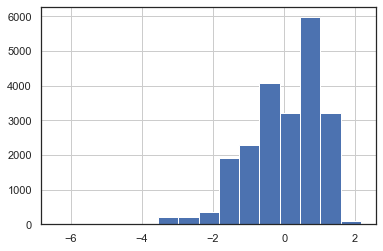

In [585]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [586]:
x_train.head()

bedrooms  bathrooms  sqft_lot    floors  sqft_above  sqft_basement  \
3902   0.059624   0.180709  1.724860  0.202361    1.661176       0.990889   
17608 -0.022653  -0.098160 -0.459320 -0.197639   -0.875740       1.416190   
1009   0.059624  -0.042562 -0.418258  0.002361   -1.026835       1.268142   
14026  0.059624  -0.042562 -0.299849 -0.197639   -0.455876       1.472700   
17575  0.059624  -0.244401 -0.368403  0.002361    0.410393      -0.798211   

           lat     long  sqft_living15  condition_(0, 2]  ...  \
3902   47.7124 -122.253       0.794765                 0  ...   
17608  47.6927 -122.395      -0.237744                 0  ...   
1009   47.6802 -122.388      -0.418492                 0  ...   
14026  47.6965 -122.393       0.640762                 0  ...   
17575  47.7188 -122.358       0.436650                 0  ...   

       yr_built_(2007, 2009]  yr_built_(2009, 2020]  Renovated?_False  \
3902                       0                      0                 1   
17608                      0                      0                 1   
1009                       0                      0                 1   
14026                      0                      0                 1   
17575                      0                      0                 1   

       Renovated?_True  prime_zipcode_False  prime_zipcode_True  grade_(0, 6]  \
3902                 0                    1                   0             0   
17608                0                    1                   0             0   
1009                 0                    1                   0             0   
14026                0                    1                   0             0   
17575                0                    1                   0             0   

       grade_(6, 9]  grade_(9, 13]  dist_from_top  
3902              0              1      -0.233077  
17608             1              0      -0.581829  
1009              1              0      -0.812883  
14026             1              0      -0.535934  
17575             1              0      -0.315850  

[5 rows x 30 columns]

In [587]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     3069.
Date:                Thu, 16 Jul 2020   Prob (F-statistic):               0.00
Time:                        20:17:35   Log-Likelihood:                -9897.6
No. Observations:               17277   AIC:                         1.985e+04
Df Residuals:                   17251   BIC:                         2.005e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     3.8515      1.371      2.810      0.005       1.165       6.538
bedrooms                 -0.4745      0.054     -8.784      0.000      -0.580      -0.369
bathrooms                 0.5662      0.040     14.004      0.000       0.487       0.645
sqft_lot                  0.1018      0.005     20.988      0.000       0.092       0.111
floors                   -0.1349      0.024     -5.698      0.000      -0.181      -0.088
sqft_above                0.3905      0.008     51.113      0.000       0.376       0.405
sqft_basement             0.1313      0.005     28.588      0.000       0.122       0.140
lat                       1.8647      0.029     64.934      0.000       1.808       1.921
long                      0.8245      0.033     24.739      0.000       0.759       0.890
sqft_living15             0.1498      0.005     28.080      0.000       0.139       0.160
condition_(0, 2]          1.7084      0.686      2.492      0.013       0.365       3.052
condition_(2, 5]          2.1431      0.686      3.126      0.002       0.799       3.487
view_0.0                 -0.2690      0.014    -18.738      0.000      -0.297      -0.241
view_3.0                  0.1459      0.025      5.763      0.000       0.096       0.196
view_4.0                  0.4294      0.035     12.216      0.000       0.361       0.498
waterfront_0.0            1.5517      0.685      2.266      0.023       0.210       2.894
waterfront_1.0            2.2998      0.687      3.349      0.001       0.954       3.646
yr_built_(1899, 1928]     0.1863      0.012     15.500      0.000       0.163       0.210
yr_built_(1928, 1933]     0.1718      0.026      6.486      0.000       0.120       0.224
yr_built_(1972, 1982]    -0.0488      0.011     -4.428      0.000      -0.070      -0.027
yr_built_(2000, 2007]     0.0327      0.012      2.689      0.007       0.009       0.057
yr_built_(2007, 2009]     0.0731      0.022      3.370      0.001       0.031       0.116
yr_built_(2009, 2020]     0.1906      0.016     12.011      0.000       0.159       0.222
Renovated?_False          1.8665      0.685      2.723      0.006       0.523       3.210
Renovated?_True           1.9850      0.685      2.896      0.004       0.641       3.328
prime_zipcode_False       1.6055      0.687      2.338      0.019       0.260       2.951
prime_zipcode_True        2.2460      0.684      3.283      0.001       0.905       3.587
grade_(0, 6]              1.0176      0.457      2.228      0.026       0.122       1.913
grade_(6, 9]              1.2267      0.457      2.684      0.007       0.331       2.122
grade_(9, 13]             1.6073      0.457      3.515      0.000       0.711       2.503
dist_from_top            -0.3599      0.006    -60.008      0.000      -0.372      -0.348
=======================

In [513]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [514]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.25634014895961005
Test Mean Squarred Error: 0.25980536497791384


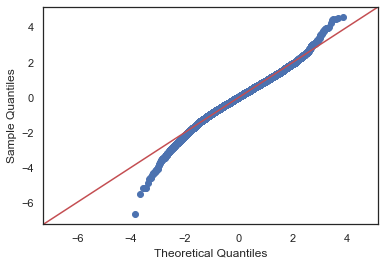

In [535]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_above", fig=fig)
plt.show()

In [516]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

[('Jarque-Bera', 312.6898358666826),
 ('Prob', 1.2596934406051084e-68),
 ('Skew', -0.22583402258188434),
 ('Kurtosis', 3.479961276139083)]

In [323]:
predictors=testing6.drop(['price','id','date'],axis=1)
predictors_int = sm.add_constant(predictors)
model = sm.OLS(testing6['price'],predictors_int).fit()
model.summary()


linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 13)
selector = selector.fit(predictors, testing6["price"])

test=predictors.columns[selector.support_]
print(test)
selector.ranking_

/Users/kiarashahmadi/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Index(['bathrooms', 'floors', 'sqft_above', 'lat', 'long', 'condition_(2, 5]',
       'view_0.0', 'view_4.0', 'waterfront_0.0', 'waterfront_1.0',
       'prime_zipcode_True', 'grade_(9, 13]', 'dist_from_top'],
      dtype='object')


array([21,  1, 23,  1,  1, 22,  1,  1, 20, 24,  7,  1,  1, 19, 11,  4,  1,
        1,  1,  5,  6, 17, 18, 16, 15, 14, 13,  8, 12,  9,  2,  1,  3, 10,
        1,  1])

In [ ]:
selected=['sqft_above', 'lat', 'condition_1', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'view_0.0', 'view_1.0', 'view_2.0',
       'view_3.0', 'view_4.0', 'waterfront_0.0', 'waterfront_1.0', 'grade_3',
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13', 'age_(0, 25]',
       'age_(25, 50]', 'age_(50, 75]', 'age_(75, 100]', 'age_(100, 125]',
       'yr_rn_0.0', 'yr_rn_1934.0', 'yr_rn_1940.0', 'yr_rn_1944.0',
       'yr_rn_1945.0', 'yr_rn_1946.0', 'yr_rn_1948.0', 'yr_rn_1950.0',
       'yr_rn_1951.0', 'yr_rn_1953.0', 'yr_rn_1954.0', 'yr_rn_1955.0',
       'yr_rn_1956.0', 'yr_rn_1957.0', 'yr_rn_1958.0', 'yr_rn_1959.0',
       'yr_rn_1960.0', 'yr_rn_1962.0', 'yr_rn_1963.0', 'yr_rn_1964.0',
       'yr_rn_1965.0', 'yr_rn_1967.0', 'yr_rn_1968.0', 'yr_rn_1969.0',
       'yr_rn_1970.0', 'yr_rn_1971.0', 'yr_rn_1972.0', 'yr_rn_1973.0',
       'yr_rn_1974.0', 'yr_rn_1975.0', 'yr_rn_1976.0', 'yr_rn_1977.0',
       'yr_rn_1978.0', 'yr_rn_1979.0', 'yr_rn_1980.0', 'yr_rn_1981.0',
       'yr_rn_1982.0', 'yr_rn_1983.0', 'yr_rn_1984.0', 'yr_rn_1985.0',
       'yr_rn_1986.0', 'yr_rn_1987.0', 'yr_rn_1988.0', 'yr_rn_1989.0',
       'yr_rn_1990.0', 'yr_rn_1991.0', 'yr_rn_1992.0', 'yr_rn_1993.0',
       'yr_rn_1994.0', 'yr_rn_1995.0', 'yr_rn_1996.0', 'yr_rn_1997.0',
       'yr_rn_1998.0', 'yr_rn_1999.0', 'yr_rn_2000.0', 'yr_rn_2001.0',
       'yr_rn_2002.0', 'yr_rn_2003.0', 'yr_rn_2004.0', 'yr_rn_2005.0',
       'yr_rn_2006.0', 'yr_rn_2007.0', 'yr_rn_2008.0', 'yr_rn_2009.0',
       'yr_rn_2010.0', 'yr_rn_2011.0', 'yr_rn_2012.0', 'yr_rn_2013.0',
       'yr_rn_2014.0', 'yr_rn_2015.0']

In [ ]:
selected==['sqft_above', 'lat', 'condition_1', 'condition_2', 'condition_3',
       'condition_4', 'condition_5', 'view_0.0', 'view_1.0', 'view_2.0',
       'view_3.0', 'view_4.0', 'waterfront_0.0', 'waterfront_1.0', 'grade_3',
       'grade_4', 'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9',
       'grade_10', 'grade_11', 'grade_12', 'grade_13', 'age_(0, 25]',
       'age_(25, 50]', 'age_(50, 75]', 'age_(75, 100]', 'age_(100, 125]',
       'yr_rn_0.0', 'yr_rn_1934.0', 'yr_rn_1940.0', 'yr_rn_1944.0',
       'yr_rn_1945.0', 'yr_rn_1946.0', 'yr_rn_1948.0', 'yr_rn_1950.0',
       'yr_rn_1951.0', 'yr_rn_1953.0', 'yr_rn_1954.0', 'yr_rn_1955.0',
       'yr_rn_1956.0', 'yr_rn_1957.0', 'yr_rn_1958.0', 'yr_rn_1959.0',
       'yr_rn_1960.0', 'yr_rn_1962.0', 'yr_rn_1963.0', 'yr_rn_1964.0',
       'yr_rn_1965.0', 'yr_rn_1967.0', 'yr_rn_1968.0', 'yr_rn_1969.0',
       'yr_rn_1970.0', 'yr_rn_1971.0', 'yr_rn_1972.0', 'yr_rn_1973.0',
       'yr_rn_1974.0', 'yr_rn_1975.0', 'yr_rn_1976.0', 'yr_rn_1977.0',
       'yr_rn_1978.0', 'yr_rn_1979.0', 'yr_rn_1980.0', 'yr_rn_1981.0',
       'yr_rn_1982.0', 'yr_rn_1983.0', 'yr_rn_1984.0', 'yr_rn_1985.0',
       'yr_rn_1986.0', 'yr_rn_1987.0', 'yr_rn_1988.0', 'yr_rn_1989.0',
       'yr_rn_1990.0', 'yr_rn_1991.0', 'yr_rn_1992.0', 'yr_rn_1993.0',
       'yr_rn_1994.0', 'yr_rn_1995.0', 'yr_rn_1996.0', 'yr_rn_1997.0',
       'yr_rn_1998.0', 'yr_rn_1999.0', 'yr_rn_2000.0', 'yr_rn_2001.0',
       'yr_rn_2002.0', 'yr_rn_2003.0', 'yr_rn_2004.0', 'yr_rn_2005.0',
       'yr_rn_2006.0', 'yr_rn_2007.0', 'yr_rn_2008.0', 'yr_rn_2009.0',
       'yr_rn_2010.0', 'yr_rn_2011.0', 'yr_rn_2012.0', 'yr_rn_2013.0',
       'yr_rn_2014.0', 'yr_rn_2015.0']

In [ ]:
aye=testing.copy()


In [ ]:
for column in aye:
    if (column  not in selected) & (column!=['price']) :
        aye.drop([column],axis=1,inplace=True)
aye.head()

In [ ]:
x=aye.copy()
y=testing.price

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=3)

In [ ]:
x_train.head()

In [ ]:
predictors_int = sm.add_constant(x_train)
model = sm.OLS(y_train,predictors_int).fit()
model.summary()

In [ ]:
predictors_test=sm.add_constant(x_test)
y_hat_train = model.predict(predictors_int)
y_hat_test = model.predict(predictors_test)

In [ ]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

In [ ]:
residuals=model.resid
fig=sm.graphics.qqplot(residuals,dist=stats.norm, line ='45', fit = True)

In [ ]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "sqft_above", fig=fig)
plt.show()

In [ ]:
name = ['Jarque-Bera','Prob','Skew', 'Kurtosis']
test = sms.jarque_bera(model.resid)
list(zip(name, test))

In [ ]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [ ]:
x=testing.drop(['price'],axis=1)
y=testing.price

In [ ]:
df2.yr_renovated.unique()

## Eliminating Outliers

The process of eliminating outliers for the continous variables consisted of simple eliminating any data point that had a Z score of over 3. This is done first by calculating the Z score as seen below.

In [134]:
df['zsqft_above']=(df.sqft_above-df.sqft_above.mean())/df.sqft_above.std()
df['zsqft_living15']=(df.sqft_living15-df.sqft_living15.mean())/df.sqft_living15.std()
df['zsqft_lot']=(df.sqft_lot-df.sqft_lot.mean())/df.sqft_lot.std()
df['zsqft_lot15']=(df.sqft_lot15-df.sqft_lot15.mean())/df.sqft_lot15.std()
df['zsqft_basement']=(df.sqft_basement-df.sqft_basement.mean())/df.sqft_basement.std()
df['zprice']=(df.price-df.price.mean())/df.price.std()

From there we eliminate any row that has a Z score of over 3 for the continous variables

In [ ]:
df=df.loc[df["zprice"]<3]
print(df.shape)
df=df.loc[df["zsqft_above"]<3]
print(df.shape)
df=df.loc[df["zsqft_living15"]<3]
print(df.shape)
df=df.loc[df["zsqft_lot"]<3]
print(df.shape)
df=df.loc[df["zsqft_lot15"]<3]
print(df.shape)
df=df.loc[df["zsqft_basement"]<3]
print(df.shape)


Once we have eliminated outliers, we no longer have the need for the z score columns.

In [ ]:
df.drop(['zprice','zsqft_above','zsqft_living15','zsqft_lot','zsqft_lot15','zsqft_basement'],axis=1,inplace=True)
df.head()